# Project Overview

People seeking care for menstrual irregularity are often told to *“eat healthier”* or *“exercise more”*, but the actual impact of these lifestyle changes is rarely explained. Without clear evidence, patients are left with limited guidance beyond medication.

## Motivation
- Medical visits often emphasize prescriptions over lifestyle counseling.  
- Patients lack population-level data on which behaviors meaningfully improve menstrual regularity.  
- This knowledge gap makes it difficult to make informed health choices.  

## Goal
Identify which lifestyle factors are most strongly associated with menstrual regularity and estimate their effect sizes. The aim is to translate these findings into practical, evidence-based recommendations that complement medical care.  

## Approach
1. **Define Outcomes**  
   - Use cycle regularity measures (e.g., self-reported regular/irregular, variability in cycle length).  

2. **Analyze Lifestyle Factors**  
   - Examine physical activity, diet, sleep, BMI, and related behaviors.  
   - Adjust for confounding variables such as age, parity, contraception, and smoking status.  

3. **Deliver Evidence-Based Guidance**  
   - Report associations with effect sizes and uncertainty.  
   - Present findings in plain language to support both clinical and personal decision-making.  


## Primary Dataset

### Outcome - Menstrual Cycle Regularity

Menstrual cycle regularity in the past 12 months was assessed by asking participants whether they experienced **regular periods**.  
- Participants reporting consistent bleeding patterns were classified as having **regular cycles**.  
- Participants reporting inconsistent or irregular bleeding patterns were classified as having **irregular cycles**, provided no major medical or physiological reason explained the irregularity.  

**Exclusion criteria.**  
To ensure that irregularity reflected only those for whom menstruation would normally be expected, participants were excluded from the irregularity classification if they reported:  
- Pregnancy  
- Postpartum or breastfeeding-related amenorrhea  
- Hysterectomy  
- Menopause  

**Additional quality checks.**  
- **Age** was used to identify and exclude outliers (e.g., implausible reports of menstruation at very young or very advanced ages).  
- **Common-sense rules** were applied to further refine classifications, ensuring the outcome measure represented biologically plausible cases of menstrual cycle regularity.  

This approach ensures that cycle irregularity is measured only among participants for whom menstrual cycles are physiologically expected under normal conditions.



In [3654]:
# Standard library
import warnings

# Environment information for reproducibility
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import sklearn 

# Third-party
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

# Global config
mpl.rcParams["axes.grid"] = False

# Suppress warnings
warnings.filterwarnings("ignore")

# Configure seaborn global theme
sns.set_theme(style="whitegrid", palette="husl")

# Define consistent colors
primary_color = sns.color_palette("husl", 8)[0]
secondary_color = sns.color_palette("husl", 8)[6]

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Python: 3.10.18
pandas: 2.1.0
numpy: 1.26.0
seaborn: 0.12.2
scikit-learn: 1.3.0
matplotlib: 3.8.0


### Environment

This notebook was run using:
- Python: 3.10.18  
- pandas: 2.1.0  
- numpy: 1.26.0  
- seaborn: 0.12.2  
- scikit-learn: 1.3.0 
- matplotlib: 3.8.0 

This version information is included to ensure reproducibility if rerun in different environments.


#### Dataset 1 - Reproductive Health

We combined reproductive health data from two NHANES cycles (2017–Pre-2020 and 2021–2023) and applied a series of cleaning steps to create a consistent outcome variable for menstrual cycle regularity.

1. **Load datasets**  
   To capture information across survey years, we imported the `P_RHQ.XPT` (2017–Pre-2020) and `RHQ_L.XPT` (2021–2023) reproductive health files.  

2. **Align structure**  
   To ensure compatibility, we identified overlapping columns between the two files and concatenated them into a single DataFrame.  

3. **Rename variables**  
   For readability and consistency, we renamed key variables:  
   - `RHQ031` → `regular_periods`  
   - `RHD043` → `irregular_period_reason`  

4. **Map categorical values**  
   To make responses interpretable, we converted `regular_periods` codes into human-readable labels:  
   - `1 = Yes`  
   - `2 = No`  
   - Other codes defaulted to `NaN`.  

5. **Exclude ineligible cases**  
   To avoid misclassification, we dropped rows where `regular_periods` was missing and excluded participants whose irregularity was explained by natural/medical conditions:  
   - Pregnancy, breastfeeding-related amenorrhea, hysterectomy, or menopause.  

6. **Retain analysis variables**  
   To prepare for downstream merging, we kept only the variables of interest:  
   - `SEQN` (participant ID)  
   - `regular_periods`  


In [3548]:
# Load reproductive health datasets (XPT files)
cycle_17_to_pre20 = pd.read_sas("data/P_RHQ.XPT")
cycle_21_to_23 = pd.read_sas("data/RHQ_L.XPT")

# Inspect dataset dimensions
print("Cycle 2017–Pre-2020:", cycle_17_to_pre20.shape)
print("Cycle 2021–2023:", cycle_21_to_23.shape)

Cycle 2017–Pre-2020: (5314, 32)
Cycle 2021–2023: (3917, 13)


In [3549]:
# Resuable to combine more dataset from different years

def combine_nhanes(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """Combine two NHANES DataFrames on overlapping columns.

    Args:
        df1: First DataFrame.
        df2: Second DataFrame.

    Returns:
        Combined DataFrame containing only the overlapping columns,
        with indices reset.
    """
    common_cols = df1.columns.intersection(df2.columns)

    combined = pd.concat(
        [df1[common_cols], df2[common_cols]],
        axis=0,
        ignore_index=True,
    )
    return combined


# Combine cycles in different years
cycle_df = combine_nhanes(cycle_17_to_pre20, cycle_21_to_23)
print("Combined shape:", cycle_df.shape)


Combined shape: (9231, 13)


In [3550]:
# Rename variables of interest
cycle_df = cycle_df.rename(
    columns={
        "RHQ031": "Regular_Periods",
        "RHD043": "Irregular_Period_Reason",
    }
)

# Map categorical values (unmapped values will become NaN)
cycle_df["Regular_Periods"] = cycle_df["Regular_Periods"].map(
    {
        1: "Yes",
        2: "No",
    }
)

cycle_df.head()

SEQN  RHQ010 Regular_Periods  Irregular_Period_Reason  RHQ060  RHQ078  \
0  109264.0    12.0             Yes                      NaN     NaN     NaN   
1  109266.0    13.0             Yes                      NaN     NaN     2.0   
2  109277.0    11.0             Yes                      NaN     NaN     NaN   
3  109279.0    12.0             Yes                      NaN     NaN     NaN   
4  109284.0     9.0             Yes                      NaN     NaN     2.0   

   RHQ131  RHD143  RHD167  RHQ200  RHD280  RHQ305  RHQ332  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     2.0     NaN     NaN     NaN     2.0     2.0     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     1.0     2.0     4.0     NaN     2.0     2.0     NaN

In [3551]:
# Drop rows where regular_periods is NaN
cycle_df = cycle_df.dropna(subset=["Regular_Periods"])

# Exclude rows where irregular_period_reason is due to medical/physiological causes
excluded_reasons = [1, 2, 3, 7]  # pregnancy, breastfeeding, hysterectomy, menopause
cycle_df = cycle_df[~cycle_df["Irregular_Period_Reason"].isin(excluded_reasons)]

# Retain only variables of interest
cycle_df = cycle_df[["SEQN", "Regular_Periods"]]


In [3552]:
cycle_df.head()

SEQN Regular_Periods
0  109264.0             Yes
1  109266.0             Yes
2  109277.0             Yes
3  109279.0             Yes
4  109284.0             Yes

#### Dataset 2 - Demographics

Demographic information was included to provide key covariates (e.g., age, race/ethnicity, education, socioeconomic status) that may influence menstrual cycle regularity and serve as important control variables in analysis.

1. **Load datasets**  
   To capture data across survey years, we imported the `P_DEMO.XPT` (2017–Pre-2020) and `DEMO_L.XPT` (2021–2023) demographic files.  

2. **Align structure**  
   We identified overlapping columns between the two datasets and concatenated them into a single demographic DataFrame.  

3. **Merge with cycle data**  
   The demographic dataset was merged with the cleaned cycle dataset using `SEQN`, the unique participant identifier.  

4. **Rename variables**  
   To improve readability and ensure consistent naming, we renamed selected variables:  
   - `RIDRETH3` → `race`  
   - `RIDAGEYR` → `age`  
   - `DMDEDUC2` → `education`  
   - `INDFMPIR` → `family_income_to_poverty_ratio`  

5. **Map categorical values**  
   We converted coded responses into human-readable categories for race/ethnicity and education.  

6. **Filter participants by age**  
   We restricted the dataset to participants aged **18–50** years:  
   - 18 was chosen as the lower bound because NHANES primarily surveys adults (18+).  
   - 50 was chosen as the upper bound, aligning with medical literature on the typical age range for menopause.  

7. **Select analysis variables**  
   We retained only the key demographic variables needed for downstream analysis:  
   - `SEQN` (participant ID)  
   - `regular_periods` (outcome from cycle data)  
   - `race`  
   - `age`  
   - `education`  
   - `family_income_to_poverty_ratio`  

In [3553]:
# Load demographic datasets (XPT files)
demo_17_to_pre20 = pd.read_sas("data/P_DEMO.XPT")
demo_21_to_23 = pd.read_sas("data/DEMO_L.XPT")

# Inspect dataset dimensions
print("Demographics 2017–Pre-2020:", demo_17_to_pre20.shape)
print("Demographics 2021–2023:", demo_21_to_23.shape)

Demographics 2017–Pre-2020: (15560, 29)
Demographics 2021–2023: (11933, 27)


In [3554]:
# Reuse combine_nhanes function to combine the dataset
demo_df = combine_nhanes(demo_17_to_pre20, demo_21_to_23)
print("Combined shape:", demo_df.shape)

Combined shape: (27493, 16)


In [3555]:
# Merge cycle and demographic datasets on SEQN (participant ID)
demo_df = pd.merge(
    cycle_df,
    demo_df,
    on="SEQN",
    how="left",
)


In [3556]:
# Rename demographic variables of interest
# Note: filtering by sex is unnecessary here since cycle data includes only females
demo_df = demo_df.rename(
    columns={
        "RIDRETH3": "Race",
        "RIDAGEYR": "Age",
        "DMDEDUC2": "Education",
        "INDFMPIR": "Family_Income_to_Poverty_Ratio",
    }
)

In [3557]:
# Map categorical values
demo_df["Race"] = demo_df["Race"].map(
    {
        1: "Mexican American",
        2: "Other Hispanic",
        3: "Non-Hispanic White",
        4: "Non-Hispanic Black",
        6: "Non-Hispanic Asian",
        7: "Other Race - Including Multi-Racial",
    }
)

demo_df["Education"] = demo_df["Education"].map(
    {
        1: "Less than 9th grade",
        2: "9–11th grade",
        3: "High school/GED",
        4: "Some college/AA",
        5: "College graduate or above",
    }
)

In [3558]:
demo_df.head()

SEQN Regular_Periods  SDDSRVYR  RIDSTATR  RIAGENDR   Age  RIDAGEMN  \
0  109264.0             Yes      66.0       2.0       2.0  13.0       NaN   
1  109266.0             Yes      66.0       2.0       2.0  29.0       NaN   
2  109277.0             Yes      66.0       2.0       2.0  12.0       NaN   
3  109279.0             Yes      66.0       2.0       2.0  17.0       NaN   
4  109284.0             Yes      66.0       2.0       2.0  44.0       NaN   

   RIDRETH1                Race  RIDEXMON  DMDBORN4  \
0       1.0    Mexican American       2.0       1.0   
1       5.0  Non-Hispanic Asian       2.0       2.0   
2       1.0    Mexican American       1.0       1.0   
3       3.0  Non-Hispanic White       2.0       1.0   
4       1.0    Mexican American       1.0       2.0   

                   Education  DMDMARTZ  RIDEXPRG  SDMVPSU  SDMVSTRA  \
0                        NaN       NaN       NaN      1.0     155.0   
1  College graduate or above       3.0       2.0      2.0     168.0   
2                        NaN       NaN       NaN      2.0     161.0   
3                        NaN       NaN       NaN      2.0     169.0   
4               9–11th grade       1.0       2.0      1.0     154.0   

   Family_Income_to_Poverty_Ratio  
0                            0.83  
1                            5.00  
2                            1.35  
3                            1.19  
4                             NaN

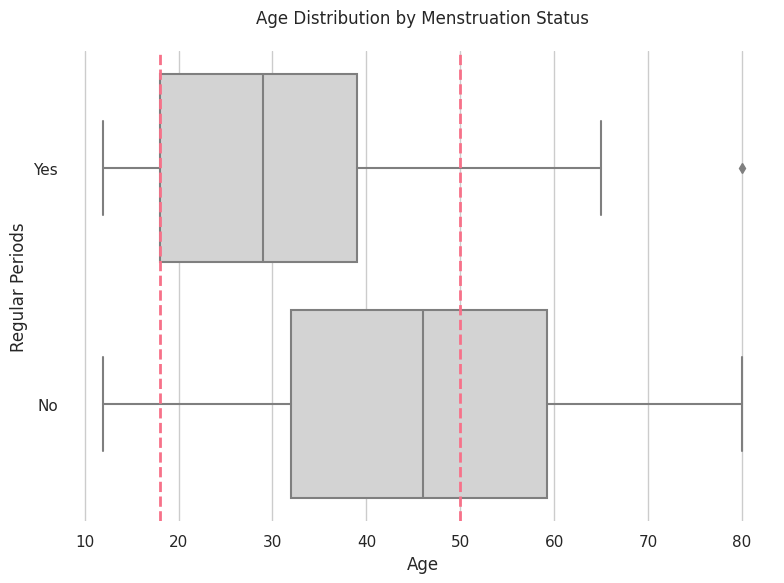

In [3559]:
# Using boxplot to examine 

plt.figure(figsize=(8, 6))
sns.boxplot(
    x="Age",
    y="Regular_Periods",
    data=demo_df,
    color="lightgray"

)
plt.axvline(x=18, color=primary_color, linestyle="--", linewidth=2, zorder=5)
plt.axvline(x=50, color=primary_color, linestyle="--", linewidth=2, zorder=5)

# Remove all axis spines (borders) and grid lines
sns.despine(left=True, bottom=True)

plt.title("Age Distribution by Menstruation Status",pad=20)
plt.xlabel("Age")
plt.ylabel("Regular Periods")
    
plt.tight_layout()
plt.show()

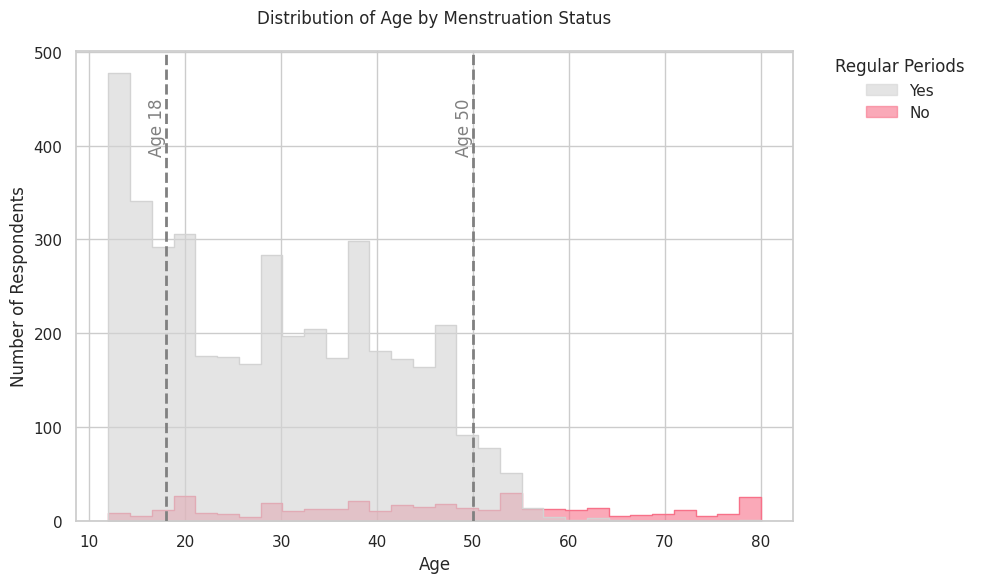

In [3560]:
# Plot a graph to explore the age and cycle data
plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=demo_df,
    x="Age",
    hue="Regular_Periods",  # Split by menstruation status
    bins=30,
    kde=False,
    element="step",         # Outlines for easier comparison
    stat="count",           # Alternative: "percent"
    alpha=0.6,
    palette={"Yes": "lightgray", "No": primary_color},
    legend=False
)

# Add vertical reference lines
plt.axvline(x=18, color="gray", linestyle="--", linewidth=2, zorder=5)
plt.axvline(x=50, color="gray", linestyle="--", linewidth=2, zorder=5)

# Labels for reference lines
plt.text(
    18,
    plt.ylim()[1] * 0.9,
    "Age 18",
    rotation=90,
    color="gray",
    ha="right",
    va="top"
)
plt.text(
    50,
    plt.ylim()[1] * 0.9,
    "Age 50",
    rotation=90,
    color="gray",
    ha="right",
    va="top"
)

plt.title("Distribution of Age by Menstruation Status", pad=20)
plt.xlabel("Age")
plt.ylabel("Number of Respondents")

# Custom legend with colored boxes
yes_patch = mpatches.Patch(color="lightgray", label="Yes", alpha=0.6)
no_patch = mpatches.Patch(color=primary_color, label="No", alpha=0.6)

ax.legend(
    handles=[yes_patch, no_patch],
    title="Regular Periods",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.show()

In [3561]:
# Drop rows where age is outside the valid range
# - Lower limit (18): some NHANES datasets only include adults (18+)
# - Upper limit (50): based on medical research on menopause
#   Source: https://www.mayoclinic.org/diseases-conditions/menopause/symptoms-causes/syc-20353397
demo_df = demo_df[(demo_df["Age"] >= 18) & (demo_df["Age"] <= 50)]

# Retain only variables of interest
primary_dataset = demo_df[
    [
        "SEQN",
        "Regular_Periods",
        "Race",
        "Age",
        "Education",
        "Family_Income_to_Poverty_Ratio",
    ]
]


In [3562]:
primary_dataset.head()

SEQN Regular_Periods                Race   Age  \
1  109266.0             Yes  Non-Hispanic Asian  29.0   
4  109284.0             Yes    Mexican American  44.0   
5  109291.0             Yes  Non-Hispanic Asian  42.0   
7  109297.0             Yes  Non-Hispanic Asian  30.0   
8  109312.0             Yes  Non-Hispanic White  48.0   

                   Education  Family_Income_to_Poverty_Ratio  
1  College graduate or above                             5.0  
4               9–11th grade                             NaN  
5  College graduate or above                             NaN  
7            Some college/AA                             NaN  
8  College graduate or above                             5.0

## Secondary Dataset - Lifestyle Data

The secondary dataset focuses on lifestyle behaviors that may influence health outcomes. It includes variables related to diet (e.g., salt usage), sleep patterns, and other daily habits.

### Body Measures: BMI and Weight Data

1. **Merging and Alignment**  
   - Combined NHANES body measures (`BMX`) and weight history (`WHQ`) datasets across cycles.  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.

2. **Variable Selection and Renaming**  
   - Retained only key variables: BMI, waist circumference, hip circumference, weight loss attempts, height, current weight, previous weight.  
   - Renamed variables to human-readable labels (e.g., `BMXWAIST → Waist_circum_cm`).

3. **Handling Invalid or Missing Codes**  
   - Replaced sentinel codes (`7777`, `9999`) with `NaN` for height and weight measures.  
   - Confirmed that only valid numeric ranges remain.

4. **Derived Variables**  
   - Created a new column `Weight_Change_lbs` = `Prev_Weight_lbs - Weight_lbs` to capture self-reported weight change.

5. **Final Dataset**  
   - Restricted to the following cleaned variables:  
     `SEQN, BMI, Waist_circum_cm, Hip_Circum_cm, Attempted_Weight_Loss, Height_in, Weight_lbs, Weight_Change_lbs`.  
   - Ensured consistent formats and confirmed valid/missing counts for BMI and weight measures.


In [3563]:
# Load body measures dataset (XPT files)
bmi_17_to_pre20 = pd.read_sas("data/P_BMX.XPT")
bmi_21_to_23 = pd.read_sas("data/BMX_L.XPT")

weight_17_to_pre20 = pd.read_sas("data/P_WHQ.XPT")
weight_21_to_23 = pd.read_sas("data/WHQ_L.XPT")

# Display dataset shapes
print(bmi_17_to_pre20.shape)
print(bmi_21_to_23.shape)
print(weight_17_to_pre20.shape)
print(weight_21_to_23.shape)

(14300, 22)
(8860, 22)
(10195, 35)
(8501, 5)


In [3564]:
# Combine NHANES body measures datasets
bmi_df = combine_nhanes(bmi_17_to_pre20, bmi_21_to_23)
weight_df = combine_nhanes(weight_17_to_pre20, weight_21_to_23)
# Check combined shape
print("BMI DataFrame shape:", bmi_df.shape)
print("Weight DataFrame shape:", weight_df.shape)


BMI DataFrame shape: (23160, 22)
Weight DataFrame shape: (18696, 5)


In [3565]:
# Merge cycle and BMI datasets on SEQN (common ID)
bmi_df = pd.merge(cycle_df, bmi_df, on="SEQN", how="left")

# Merge weight dataset
bmi_df = pd.merge(bmi_df, weight_df, on="SEQN", how="left")


In [3566]:
# Rename variables of interest
bmi_df.rename(
    columns={
        "BMXBMI": "BMI",
        "BMXWAIST": "Waist_circum_cm",
        "BMXHIP": "Hip_Circum_cm",
        "WHQ070": "Attempted_Weight_Loss",
        "WHD010": "Height_in",
        "WHD020": "Weight_lbs",
        "WHD050": "Prev_Weight_lbs",
    },
    inplace=True,
)


In [3567]:
# Map categorical values
bmi_df["Attempted_Weight_Loss"] = bmi_df["Attempted_Weight_Loss"].map(
    {1: "Yes", 2: "No"}
)

# Replace special codes with NaN (retain valid ranges)
bmi_df["Height_in"] = bmi_df["Height_in"].replace({7777: np.nan, 9999: np.nan})
bmi_df["Weight_lbs"] = bmi_df["Weight_lbs"].replace({7777: np.nan, 9999: np.nan})
bmi_df["Prev_Weight_lbs"] = bmi_df["Prev_Weight_lbs"].replace({7777: np.nan, 9999: np.nan})

In [3568]:
# Add calculated column for weight change (previous - current)
bmi_df["Weight_Change_lbs"] = bmi_df["Prev_Weight_lbs"] - bmi_df["Weight_lbs"]

In [3569]:
# Retain variables of interest only
bmi_df = bmi_df[
    [
        "SEQN",
        "BMI",
        "Waist_circum_cm",
        "Hip_Circum_cm",
        "Attempted_Weight_Loss",
        "Height_in",
        "Weight_lbs",
        "Weight_Change_lbs",
    ]
]

In [3570]:
# Get a preview of the BMI dataset
bmi_df.head()

SEQN   BMI  Waist_circum_cm  Hip_Circum_cm Attempted_Weight_Loss  \
0  109264.0  17.6             63.8           85.0                   NaN   
1  109266.0  37.8            117.9          126.1                   Yes   
2  109277.0  18.6             67.6           88.6                   NaN   
3  109279.0  21.0             77.4           90.3                    No   
4  109284.0  39.1            103.1          125.5                   Yes   

   Height_in  Weight_lbs  Weight_Change_lbs  
0        NaN         NaN                NaN  
1       64.0       210.0              -10.0  
2        NaN         NaN                NaN  
3       64.0       122.0               -8.0  
4       60.0       178.0               -8.0

In [3571]:
# Confirm only valid values remain in the BMI field
print(bmi_df["BMI"].value_counts())

# Check value and missing counts
print("Values:", bmi_df["BMI"].value_counts().sum())
print("N/A:", bmi_df["BMI"].isna().sum())
print("Total:", len(bmi_df["BMI"]))

BMI
26.1    39
22.3    34
21.6    34
22.2    33
22.6    32
        ..
66.2     1
57.9     1
40.3     1
77.3     1
14.9     1
Name: count, Length: 429, dtype: int64
Values: 4418
N/A: 41
Total: 4459


### Smoking Data

1. **Merging and Alignment**  
   - Combined NHANES smoking datasets across cycles (cigarette use, household exposure, and tobacco use).  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.  

2. **Variable Selection and Renaming**  
   - Retained key smoking-related variables:  
     - `Smoked_100`: Ever smoked at least 100 cigarettes in life  
     - `Active_Smoker`: Current smoking status  
     - `Lifetime_Cig_Count`: Lifetime cigarette consumption categories  
     - `Household_Smoker_Count`: Number of smokers in the household  
     - `Last_Cig`: Time since last cigarette  
   - Renamed variables for clarity and consistency.  

3. **Handling Invalid or Miscoded Values**  
   - Converted sentinel codes to `NaN` where appropriate.  
   - Corrected cases where `0` was misinterpreted as an IBM float (`5.3976e-79`).  

4. **Categorical Mapping**  
   - Recoded numeric values into meaningful categorical labels (e.g., `1 → Yes`, `2 → No`, `1 → Every day`, `2 → Some days`).  
   - Standardized categories for consistency across the dataset.  

5. **Final Dataset**  
   - Restricted to cleaned variables:  
     `SEQN, Smoked_100, Active_Smoker, Lifetime_Cig_Count, Household_Smoker_Count, Last_Cig`.  
   - Verified that only specified values remain in each field, with missing data handled consistently.


In [3572]:
# Load smoking datasets (XPT files)
smoking_cig_17_to_pre20 = pd.read_sas("data/P_SMQ.XPT")
smoking_cig_21_to_23 = pd.read_sas("data/SMQ_L.XPT")

smoking_house_17_to_pre20 = pd.read_sas("data/P_SMQFAM.XPT")
smoking_house_21_to_23 = pd.read_sas("data/SMQFAM_L.XPT")

smoking_tobacco_17_to_pre20 = pd.read_sas("data/P_SMQRTU.XPT")
smoking_tobacco_21_to_23 = pd.read_sas("data/SMQRTU_L.XPT")

# Display dataset shapes
print("Cigarette dataset shapes:", smoking_cig_17_to_pre20.shape, smoking_cig_21_to_23.shape)
print("Household smoking dataset shapes:", smoking_house_17_to_pre20.shape, smoking_house_21_to_23.shape)
print("Tobacco dataset shapes:", smoking_tobacco_17_to_pre20.shape, smoking_tobacco_21_to_23.shape)

Cigarette dataset shapes: (11137, 16) (9015, 9)
Household smoking dataset shapes: (15560, 3) (11933, 3)
Tobacco dataset shapes: (10409, 25) (7199, 21)


In [3573]:
# Combine NHANES smoking datasets
smoking_cig_df = combine_nhanes(smoking_cig_17_to_pre20, smoking_cig_21_to_23)
smoking_house_df = combine_nhanes(smoking_house_17_to_pre20, smoking_house_21_to_23)
smoking_tobacco_df = combine_nhanes(smoking_tobacco_17_to_pre20, smoking_tobacco_21_to_23)

# Check combined shapes
print("Cigarette DataFrame shape:", smoking_cig_df.shape)
print("Household smoking DataFrame shape:", smoking_house_df.shape)
print("Tobacco DataFrame shape:", smoking_tobacco_df.shape)

Cigarette DataFrame shape: (20152, 9)
Household smoking DataFrame shape: (27493, 3)
Tobacco DataFrame shape: (17608, 20)


In [3574]:
# Merge cycle_df with smoking datasets on SEQN (common ID)
smoking_df = pd.merge(primary_dataset, smoking_cig, on="SEQN", how="left")
smoking_df = pd.merge(smoking_df, smoking_house, on="SEQN", how="left")
smoking_df = pd.merge(smoking_df, smoking_tobacco, on="SEQN", how="left")

In [3575]:
# Rename variables of interest
smoking_df.rename(
    columns={
        "SMQ020": "Smoked_100",
        "SMQ040": "Active_Smoker",
        "SMQ621": "Lifetime_Cig_Count",
        "SMD460": "Household_Smoker_Count",
        "SMQ725": "Last_Cig",
    },
    inplace=True,
)

In [3576]:
# Map categorical values
smoking_df["Smoked_100"] = smoking_df["Smoked_100"].map(
    {1: "Yes", 2: "No"}
)

smoking_df["Active_Smoker"] = smoking_df["Active_Smoker"].map(
    {
        1: "Every day",
        2: "Some days",
        3: "Not at all",
    }
)

smoking_df["Lifetime_Cig_Count"] = smoking_df["Lifetime_Cig_Count"].map(
    {
        1: 0,
        2: "<1",
        3: 1,
        4: "2 to 5",
        5: "6 to 15",
        6: "16 to 25",
        7: "26 to 99",
        8: "100+",
    }
)

smoking_df["Household_Smoker_Count"] = smoking_df["Household_Smoker_Count"].map(
    {
        5.397605346934028e-79: 0,  # edge case: 0 misread as IBM float
        1: 1,
        2: "2+",
    }
)

smoking_df["Last_Cig"] = smoking_df["Last_Cig"].map(
    {
        1: "Today",
        2: "Yesterday",
        3: "3 to 5 days ago",
    }
)

In [3577]:
# Retain variables of interest only
smoking_df = smoking_df[
    [
        "SEQN",
        "Smoked_100",
        "Active_Smoker",
        "Lifetime_Cig_Count",
        "Household_Smoker_Count",
        "Last_Cig",
    ]
]

In [3578]:
# Get a preview of the BMI dataset
smoking_df.head()

SEQN Smoked_100 Active_Smoker Lifetime_Cig_Count  \
0  109266.0         No           NaN                NaN   
1  109284.0         No           NaN                NaN   
2  109291.0         No           NaN                NaN   
3  109297.0         No           NaN                NaN   
4  109312.0         No           NaN                NaN   

  Household_Smoker_Count   Last_Cig  
0                      0        NaN  
1                      0        NaN  
2                      0        NaN  
3                      0  Yesterday  
4                      0        NaN

In [3579]:
# Confirm only valid values remain in the Smoked_100 field
print(smoking_df["Smoked_100"].value_counts())

# Check counts of valid and missing values
print("Values:", smoking_df["Smoked_100"].value_counts().sum())
print("N/A:", smoking_df["Smoked_100"].isna().sum())
print("Total:", len(smoking_df["Smoked_100"]))

Smoked_100
No     2315
Yes     825
Name: count, dtype: int64
Values: 3140
N/A: 3
Total: 3143


### Alcohol Data

1. **Merging and Alignment**  
   - Combined NHANES alcohol datasets across cycles (2017–pre2020 and 2021–2023).  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.  

2. **Variable Selection and Renaming**  
   - Retained key alcohol-related variables:  
     - `Alc_Freq`: Frequency of alcohol consumption  
     - `Daily_Drinks`: Typical number of drinks per day  
   - Renamed variables for clarity and consistency.  

3. **Handling Invalid or Miscoded Values**  
   - Corrected IBM float artifact where `0` was misread as `5.3976e-79` and mapped it to `"Never"`.  
   - Replaced sentinel codes (`777`, `999`) with `NaN` to represent missing or invalid responses.  

4. **Categorical Mapping**  
   - Recoded numeric categories for `Alc_Freq` into interpretable labels (e.g., `1 → Every Day`, `5 → 1x/wk`).  
   - Collapsed `Daily_Drinks` values of `15` into `"15+"` to represent extreme intake.  

5. **Final Dataset**  
   - Restricted to cleaned variables: `SEQN, Alc_Freq, Daily_Drinks`.  
   - Verified that only specified values remain in fields, with missing data consistently handled.  


In [3580]:
# Load alcohol datasets (XPT files)
alcohol_17_to_pre20 = pd.read_sas("data/P_ALQ.XPT")
alcohol_21_to_23 = pd.read_sas("data/ALQ_L.XPT")

# Display dataset shapes
print("Alcohol 2017–pre2020 shape:", alcohol_17_to_pre20.shape)
print("Alcohol 2021–2023 shape:", alcohol_21_to_23.shape)

Alcohol 2017–pre2020 shape: (8965, 10)
Alcohol 2021–2023 shape: (6337, 9)


In [3581]:
# Combine NHANES alcohol datasets
alcohol_df = combine_nhanes(alcohol_17_to_pre20, alcohol_21_to_23)

# Display combined shape
print("Alcohol DataFrame shape:", alcohol_df.shape)

Alcohol DataFrame shape: (15302, 9)


In [3582]:
# Merge cycle_df and alcohol_df on SEQN (common ID)
alcohol_df = pd.merge(primary_dataset, alcohol_df, on="SEQN", how="left")

In [3583]:
# Rename variables of interest
alcohol_df.rename(
    columns={
        "ALQ121": "Alc_Freq",
        "ALQ130": "Daily_Drinks",
    },
    inplace=True,
)

In [3584]:
# Map categorical values for alcohol frequency
alcohol_df["Alc_Freq"] = alcohol_df["Alc_Freq"].map(
    {
        5.397605346934028e-79: "Never",  # edge case: 0 misread as IBM float
        1: "Every Day",
        2: "Nearly Every Day",
        3: "3-4x/wk",
        4: "2x/wk",
        5: "1x/wk",
        6: "2-3x/mo",
        7: "1x/mo",
        8: "7-11x/yr",
        9: "3-6x/yr",
        10: "1-2x/yr",
    }
)

# Replace invalid/miscoded values in daily drinks
alcohol_df["Daily_Drinks"] = (
    alcohol_df["Daily_Drinks"]
    .replace({15: "15+"})   # collapse 15 into "15+"
    .replace({777: np.nan, 999: np.nan})  # sentinel codes → NaN
)

In [3585]:
# Retain variables of interest only
alcohol_df = alcohol_df[
    [
        "SEQN",
        "Alc_Freq",
        "Daily_Drinks",
    ]
]

In [3586]:
# Get a preview of the BMI dataset
alcohol_df.head()

SEQN Alc_Freq Daily_Drinks
0  109266.0  1-2x/yr          1.0
1  109284.0      NaN          NaN
2  109291.0      NaN          NaN
3  109297.0  2-3x/mo          2.0
4  109312.0  3-6x/yr          1.0

In [3587]:
# Confirm only valid values remain in Alc_Freq
print(alcohol_df["Alc_Freq"].value_counts())

# Check counts of valid and missing values
print("Values:", alcohol_df["Alc_Freq"].value_counts().sum())
print("N/A:", alcohol_df["Alc_Freq"].isna().sum())
print("Total:", len(alcohol_df["Alc_Freq"]))

Alc_Freq
2-3x/mo             510
3-6x/yr             401
1-2x/yr             391
Never               289
1x/mo               250
2x/wk               239
1x/wk               231
7-11x/yr            194
3-4x/wk             171
Nearly Every Day     64
Every Day            30
Name: count, dtype: int64
Values: 2770
N/A: 373
Total: 3143


### Physical Activity Data

1. **Merging and Alignment**  
   - Combined NHANES physical activity datasets across cycles (2017–pre2020 and 2021–2023).  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.  

2. **Variable Selection and Renaming**  
   - Retained key activity-related variables: sedentary time, frequency, minutes, and duration of moderate/vigorous physical activity (work and recreational).  
   - Renamed variables to descriptive labels for clarity.  

3. **Handling Invalid or Miscoded Values**  
   - Replaced sentinel codes (`77`, `99`, `7777`, `9999`) with `NaN` to represent missing responses.  
   - Corrected IBM float artifact (`5.3976e-79`) misinterpreted as `0`.  

4. **Categorical Mapping**  
   - Converted unit codes (`D`, `W`, `M`, `Y`) into both numeric multipliers (per year) and human-readable text labels (e.g., `"day(s)"`).  

5. **Derived Variables**  
   - Calculated hours of moderate and vigorous activity per week.  
   - Combined self-report (unit-based) and work/recreational activity data into unified weekly measures.  
   - Created frequency strings with unit labels (e.g., `"3x/ week"`).  

6. **Final Dataset**  
   - Restricted to cleaned variables:  
     `SEQN, Sedentary_Hrs_Wk, Moderate_LTPA_Freq, Moderate_LTPA_Mins, Moderate_LTPA_Hrs_Wk, Vigorous_LTPA_Freq, Vigorous_LTPA_Mins, Vigorous_LTPA_Hrs_Wk`.  
   - Ensured missing values are consistently represented and variables are standardized for analysis.  


In [3588]:
# Load physical activity datasets (XPT files)
exercise_17_to_pre20 = pd.read_sas("data/P_PAQ.XPT")
exercise_21_to_23 = pd.read_sas("data/PAQ_L.XPT")

# Display dataset shapes
print("Physical activity 2017–pre2020 shape:", exercise_17_to_pre20.shape)
print("Physical activity 2021–2023 shape:", exercise_21_to_23.shape)

Physical activity 2017–pre2020 shape: (9693, 17)
Physical activity 2021–2023 shape: (8153, 8)


In [3589]:
# Combine physical activity datasets (keep all columns)
exercise_df = pd.concat(
    [exercise_17_to_pre20, exercise_21_to_23],
    axis=0,
    ignore_index=True,
)

# Display combined shape
print("Exercise DataFrame shape:", exercise_df.shape)

Exercise DataFrame shape: (17846, 23)


In [3590]:
# Merge cycle_df with exercise_df on SEQN (common ID)
exercise_df = pd.merge(primary_dataset, exercise_df, on="SEQN", how="left")

In [3591]:
# Rename variables of interest
exercise_df.rename(
    columns={
        "PAD680": "Sedentary_Mins",
        "PAD790Q": "Moderate_LTPA_Freq_1",
        "PAD790U": "Moderate_LTPA_Units",
        "PAD800": "Moderate_LTPA_Mins_1",
        "PAD810Q": "Vigorous_LTPA_Freq_1",
        "PAD810U": "Vigorous_LTPA_Units",
        "PAD820": "Vigorous_LTPA_Mins_1",
        "PAQ610": "Vigorous_LTPA_Freq_Work",
        "PAD615": "Vigorous_LTPA_Mins_Work",
        "PAQ625": "Moderate_LTPA_Freq_Work",
        "PAD630": "Moderate_LTPA_Mins_Work",
        "PAQ655": "Vigorous_LTPA_Freq_Rec",
        "PAD660": "Vigorous_LTPA_Mins_Rec",
        "PAQ670": "Moderate_LTPA_Freq_Rec",
        "PAD675": "Moderate_LTPA_Mins_Rec",
    },
    inplace=True,
)

In [3592]:
# Map categorical values for activity unit conversions
exercise_df["Moderate_LTPA_Units_Math"] = exercise_df["Moderate_LTPA_Units"].map(
    {b"D": 365, b"M": 12, b"W": 52, b"Y": 1}
)
exercise_df["Moderate_LTPA_Units_Text"] = exercise_df["Moderate_LTPA_Units"].map(
    {b"D": "day(s)", b"M": "month(s)", b"W": "week(s)", b"Y": "year(s)"}
)
exercise_df["Vigorous_LTPA_Units_Math"] = exercise_df["Vigorous_LTPA_Units"].map(
    {b"D": 365, b"M": 12, b"W": 52, b"Y": 1}
)
exercise_df["Vigorous_LTPA_Units_Text"] = exercise_df["Vigorous_LTPA_Units"].map(
    {b"D": "day(s)", b"M": "month(s)", b"W": "week(s)", b"Y": "year(s)"}
)

# Replace invalid/miscoded values with NaN
exercise_df["Sedentary_Mins"] = exercise_df["Sedentary_Mins"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Moderate_LTPA_Freq_1"] = exercise_df["Moderate_LTPA_Freq_1"].replace(
    {5.397605346934028e-79: 0, 7777: np.nan, 9999: np.nan}
)
exercise_df["Moderate_LTPA_Mins_1"] = exercise_df["Moderate_LTPA_Mins_1"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Vigorous_LTPA_Freq_1"] = exercise_df["Vigorous_LTPA_Freq_1"].replace(
    {5.397605346934028e-79: 0, 7777: np.nan, 9999: np.nan}
)
exercise_df["Vigorous_LTPA_Mins_1"] = exercise_df["Vigorous_LTPA_Mins_1"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Moderate_LTPA_Freq_Work"] = exercise_df["Moderate_LTPA_Freq_Work"].replace(
    {77: np.nan, 99: np.nan}
)
exercise_df["Moderate_LTPA_Mins_Work"] = exercise_df["Moderate_LTPA_Mins_Work"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Vigorous_LTPA_Freq_Work"] = exercise_df["Vigorous_LTPA_Freq_Work"].replace(
    {77: np.nan, 99: np.nan}
)
exercise_df["Vigorous_LTPA_Mins_Work"] = exercise_df["Vigorous_LTPA_Mins_Work"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Moderate_LTPA_Freq_Rec"] = exercise_df["Moderate_LTPA_Freq_Rec"].replace(
    {77: np.nan, 99: np.nan}
)
exercise_df["Moderate_LTPA_Mins_Rec"] = exercise_df["Moderate_LTPA_Mins_Rec"].replace(
    {7777: np.nan, 9999: np.nan}
)

exercise_df["Vigorous_LTPA_Freq_Rec"] = exercise_df["Vigorous_LTPA_Freq_Rec"].replace(
    {77: np.nan, 99: np.nan}
)
exercise_df["Vigorous_LTPA_Mins_Rec"] = exercise_df["Vigorous_LTPA_Mins_Rec"].replace(
    {7777: np.nan, 9999: np.nan}
)

In [3593]:
# ---- Derived activity metrics ----

# Sedentary hours per week
exercise_df["Sedentary_Hrs_Wk"] = exercise_df["Sedentary_Mins"] / 60 * 7

# Hours per week (section 1 uses unit converters → per year, then /52)
exercise_df["Moderate_LTPA_Hrs_Wk_1"] = (
    exercise_df["Moderate_LTPA_Freq_1"]
    * exercise_df["Moderate_LTPA_Units_Math"].fillna(0).astype(int)
    * exercise_df["Moderate_LTPA_Mins_1"]
    / 60
    / 52
)
exercise_df["Vigorous_LTPA_Hrs_Wk_1"] = (
    exercise_df["Vigorous_LTPA_Freq_1"]
    * exercise_df["Vigorous_LTPA_Units_Math"].fillna(0).astype(int)
    * exercise_df["Vigorous_LTPA_Mins_1"]
    / 60
    / 52
)

# Hours per week (work & recreation are already weekly)
exercise_df["Moderate_LTPA_Hrs_Wk_Work"] = (
    exercise_df["Moderate_LTPA_Freq_Work"] * exercise_df["Moderate_LTPA_Mins_Work"] / 60
)
exercise_df["Moderate_LTPA_Hrs_Wk_Rec"] = (
    exercise_df["Moderate_LTPA_Freq_Rec"] * exercise_df["Moderate_LTPA_Mins_Rec"] / 60
)
exercise_df["Vigorous_LTPA_Hrs_Wk_Work"] = (
    exercise_df["Vigorous_LTPA_Freq_Work"] * exercise_df["Vigorous_LTPA_Mins_Work"] / 60
)
exercise_df["Vigorous_LTPA_Hrs_Wk_Rec"] = (
    exercise_df["Vigorous_LTPA_Freq_Rec"] * exercise_df["Vigorous_LTPA_Mins_Rec"] / 60
)

# Combine work & recreation hours (weekly)
exercise_df["Moderate_LTPA_Hrs_Wk_2"] = (
    exercise_df["Moderate_LTPA_Hrs_Wk_Work"] + exercise_df["Moderate_LTPA_Hrs_Wk_Rec"]
)
exercise_df["Vigorous_LTPA_Hrs_Wk_2"] = (
    exercise_df["Vigorous_LTPA_Hrs_Wk_Work"] + exercise_df["Vigorous_LTPA_Hrs_Wk_Rec"]
)

# Final weekly hours (prefer section 1; fallback to work+rec)
exercise_df["Moderate_LTPA_Hrs_Wk"] = exercise_df["Moderate_LTPA_Hrs_Wk_1"].combine_first(
    exercise_df["Moderate_LTPA_Hrs_Wk_2"]
)
exercise_df["Vigorous_LTPA_Hrs_Wk"] = exercise_df["Vigorous_LTPA_Hrs_Wk_1"].combine_first(
    exercise_df["Vigorous_LTPA_Hrs_Wk_2"]
)

# Combine work & recreation frequencies / minutes
exercise_df["Moderate_LTPA_Freq_2"] = (
    exercise_df["Moderate_LTPA_Freq_Work"] + exercise_df["Moderate_LTPA_Freq_Rec"]
)
exercise_df["Vigorous_LTPA_Freq_2"] = (
    exercise_df["Vigorous_LTPA_Freq_Work"] + exercise_df["Vigorous_LTPA_Freq_Rec"]
)
exercise_df["Moderate_LTPA_Mins_2"] = (
    exercise_df["Moderate_LTPA_Mins_Work"] + exercise_df["Moderate_LTPA_Mins_Rec"]
)
exercise_df["Vigorous_LTPA_Mins_2"] = (
    exercise_df["Vigorous_LTPA_Mins_Work"] + exercise_df["Vigorous_LTPA_Mins_Rec"]
)

# Frequency labels with units (avoid 'nanx/')
exercise_df["Moderate_LTPA_Freq_Units_1"] = np.where(
    exercise_df["Moderate_LTPA_Freq_1"].notna(),
    exercise_df["Moderate_LTPA_Freq_1"].astype("Int64").astype(str)
    + "x/ "
    + exercise_df["Moderate_LTPA_Units_Text"].fillna(""),
    np.nan,
)
exercise_df["Vigorous_LTPA_Freq_Units_1"] = np.where(
    exercise_df["Vigorous_LTPA_Freq_1"].notna(),
    exercise_df["Vigorous_LTPA_Freq_1"].astype("Int64").astype(str)
    + "x/ "
    + exercise_df["Vigorous_LTPA_Units_Text"].fillna(""),
    np.nan,
)
exercise_df["Moderate_LTPA_Freq_Units_2"] = np.where(
    exercise_df["Moderate_LTPA_Freq_2"].notna(),
    exercise_df["Moderate_LTPA_Freq_2"].astype("Int64").astype(str) + "x/ week",
    np.nan,
)
exercise_df["Vigorous_LTPA_Freq_Units_2"] = np.where(
    exercise_df["Vigorous_LTPA_Freq_2"].notna(),
    exercise_df["Vigorous_LTPA_Freq_2"].astype("Int64").astype(str) + "x/ week",
    np.nan,
)

# Final frequency/minutes (prefer section 1; fallback to work+rec)
exercise_df["Moderate_LTPA_Freq"] = exercise_df["Moderate_LTPA_Freq_Units_1"].combine_first(
    exercise_df["Moderate_LTPA_Freq_Units_2"]
)
exercise_df["Vigorous_LTPA_Freq"] = exercise_df["Vigorous_LTPA_Freq_Units_1"].combine_first(
    exercise_df["Vigorous_LTPA_Freq_Units_2"]
)
exercise_df["Moderate_LTPA_Mins"] = exercise_df["Moderate_LTPA_Mins_1"].combine_first(
    exercise_df["Moderate_LTPA_Mins_2"]
)
exercise_df["Vigorous_LTPA_Mins"] = exercise_df["Vigorous_LTPA_Mins_1"].combine_first(
    exercise_df["Vigorous_LTPA_Mins_2"]
)

In [3594]:
# Retain variables of interest only
exercise_df = exercise_df[
    [
        "SEQN",
        "Sedentary_Hrs_Wk",
        "Moderate_LTPA_Freq",
        "Moderate_LTPA_Mins",
        "Moderate_LTPA_Hrs_Wk",
        "Vigorous_LTPA_Freq",
        "Vigorous_LTPA_Mins",
        "Vigorous_LTPA_Hrs_Wk",
    ]
]

In [3595]:
# Get a preview of the exercise dataset
exercise_df.head()

SEQN  Sedentary_Hrs_Wk Moderate_LTPA_Freq  Moderate_LTPA_Mins  \
0  109266.0              56.0                NaN                 NaN   
1  109284.0              42.0                NaN                 NaN   
2  109291.0              63.0                NaN                 NaN   
3  109297.0              70.0                NaN                 NaN   
4  109312.0              21.0          12x/ week               480.0   

   Moderate_LTPA_Hrs_Wk Vigorous_LTPA_Freq  Vigorous_LTPA_Mins  \
0                   NaN                NaN                 NaN   
1                   NaN                NaN                 NaN   
2                   NaN                NaN                 NaN   
3                   NaN                NaN                 NaN   
4                  52.0                NaN                 NaN   

   Vigorous_LTPA_Hrs_Wk  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [3596]:
# Confirm only valid values remain in Moderate_LTPA_Hrs_Wk
print(exercise_df["Moderate_LTPA_Hrs_Wk"].value_counts())

# Check counts of valid and missing values
print("Values:", exercise_df["Moderate_LTPA_Hrs_Wk"].value_counts().sum())
print("N/A:", exercise_df["Moderate_LTPA_Hrs_Wk"].isna().sum())
print("Total:", len(exercise_df["Moderate_LTPA_Hrs_Wk"]))

Moderate_LTPA_Hrs_Wk
3.000000     106
1.000000      98
2.000000      95
1.500000      84
4.000000      52
            ... 
60.000000      1
4.416667       1
28.500000      1
4.750000       1
1.250000       1
Name: count, Length: 230, dtype: int64
Values: 1423
N/A: 1720
Total: 3143


### Dietary

1. **Merging and Alignment**  
   - Combined NHANES dietary datasets across cycles (2017–pre2020 and 2021–2023).  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.  

2. **Variable Selection and Renaming**  
   - Retained key dietary and nutrition-related variables, including health perception, eating habits, salt use, dieting status, water intake, and dietary supplements.  
   - Renamed variables to descriptive labels for clarity.  

3. **Handling Invalid or Miscoded Values**  
   - Corrected IBM float artifact (`5.3976e-79`) misinterpreted as `0`.  
   - Replaced sentinel codes (`5555`, `7777`, `9999`) with appropriate labels (`">21"`) or `NaN` where responses were missing.  

4. **Categorical Mapping**  
   - Converted numeric responses into interpretable categories:  
     - `Healthiness` → Excellent, Very good, Good, Fair, Poor  
     - `Salt_Used` → Never, Rarely, Occasionally, Very often  
     - `On_Diet` and `Dietary_Supp` → Yes/No  
   - Recoded diet-related behaviors (e.g., Ate less, Lower cals, Less fat, Skipped meals, Fewer carbs, Less sugar, Less junk).  

5. **Final Dataset**  
   - Restricted to cleaned variables:  
     `SEQN, Healthiness, Meals_Not_From_Home_Wk, Meals_From_Fast_Food_Wk, Salt_Used, On_Diet, Water_Day, Ate_Less, Lower_Cals, Less_Fat, Skipped_Meals, Diet_Foods, Fewer_Carbs, Less_Sugar, Less_Junk, Dietary_Supp`.  
   - Ensured missing values are consistently handled and only valid responses remain.  


In [3597]:
# Load dietary dataset XPT files

# Dietary behavior
dietary_behavior_17_to_pre20 = pd.read_sas("data/P_DBQ.XPT")
dietary_behavior_21_to_23 = pd.read_sas("data/DBQ_L.XPT")

# Dietary interview (24-hour recall totals)
dietary_interview_17_to_pre20 = pd.read_sas("data/P_DR1TOT.XPT")
dietary_interview_21_to_23 = pd.read_sas("data/DR1TOT_L.XPT")

# Weight history
weight_history_17_to_pre20 = pd.read_sas("data/P_WHQ.XPT")
weight_history_21_to_23 = pd.read_sas("data/WHQ_L.XPT")

# Dietary supplement totals
dietary_supp_17_to_pre20 = pd.read_sas("data/P_DSQTOT.XPT")
dietary_supp_21_to_23 = pd.read_sas("data/DSQTOT_L.XPT")

In [3598]:
# Combine dietary datasets (keep all columns)
dietary_behavior = pd.concat(
    [dietary_behavior_17_to_pre20, dietary_behavior_21_to_23],
    axis=0,
    ignore_index=True,
)

dietary_interview = pd.concat(
    [dietary_interview_17_to_pre20, dietary_interview_21_to_23],
    axis=0,
    ignore_index=True,
)

weight_history = pd.concat(
    [weight_history_17_to_pre20, weight_history_21_to_23],
    axis=0,
    ignore_index=True,
)

dietary_supp = pd.concat(
    [dietary_supp_17_to_pre20, dietary_supp_21_to_23],
    axis=0,
    ignore_index=True,
)


In [3599]:
# Merge cycle and dietary datasets on SEQN (common ID)
dietary_df = pd.merge(primary_dataset, dietary_behavior, on="SEQN", how="left")
dietary_df = pd.merge(dietary_df, dietary_interview, on="SEQN", how="left")
dietary_df = pd.merge(dietary_df, weight_history, on="SEQN", how="left")
dietary_df = pd.merge(dietary_df, dietary_supp, on="SEQN", how="left")

In [3600]:
# Rename variables of interest
dietary_df.rename(
    columns={
        "DBQ700": "Healthiness",
        "DBD895": "Meals_Not_From_Home_Wk",
        "DBD900": "Meals_From_Fast_Food_Wk",
        "DRQSPREP": "Salt_Used",
        "DRQSDIET": "On_Diet",
        "DR1_320Z": "Water_Day",
        "WHD080A": "Ate_Less",
        "WHD080B": "Lower_Cals",
        "WHD080C": "Less_Fat",
        "WHD080E": "Skipped_Meals",
        "WHD080F": "Diet_Foods",
        "WHD080O": "Fewer_Carbs",
        "WHD080S": "Less_Sugar",
        "WHD080T": "Less_Junk",
        "DSD010": "Dietary_Supp",
    },
    inplace=True,
)

In [3601]:
# Map categorical values
dietary_df["Healthiness"] = dietary_df["Healthiness"].map(
    {
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
    }
)

dietary_df["Salt_Used"] = dietary_df["Salt_Used"].map(
    {
        1: "Never",
        2: "Rarely",
        3: "Occasionally",
        4: "Very often",
    }
)

dietary_df["On_Diet"] = dietary_df["On_Diet"].map({1: "Yes", 2: "No"})
dietary_df["Dietary_Supp"] = dietary_df["Dietary_Supp"].map({1: "Yes", 2: "No"})

# Replace miscoded/range values while retaining valid ranges
dietary_df["Meals_Not_From_Home_Wk"] = dietary_df["Meals_Not_From_Home_Wk"].replace(
    {5.397605346934028e-79: "None", 5555: ">21", 7777: np.nan, 9999: np.nan}
)

dietary_df["Meals_From_Fast_Food_Wk"] = dietary_df["Meals_From_Fast_Food_Wk"].replace(
    {5.397605346934028e-79: "None", 5555: ">21", 7777: np.nan, 9999: np.nan}
)

dietary_df["Ate_Less"] = dietary_df["Ate_Less"].replace({10: "Ate less"})
dietary_df["Lower_Cals"] = dietary_df["Lower_Cals"].replace({11: "Lower cals"})
dietary_df["Less_Fat"] = dietary_df["Less_Fat"].replace({12: "Less fat"})
dietary_df["Skipped_Meals"] = dietary_df["Skipped_Meals"].replace({14: "Skipped meals"})
dietary_df["Diet_Foods"] = dietary_df["Diet_Foods"].replace({15: "Diet foods"})
dietary_df["Fewer_Carbs"] = dietary_df["Fewer_Carbs"].replace({41: "Fewer carbs"})
dietary_df["Less_Sugar"] = dietary_df["Less_Sugar"].replace({45: "Less sugar"})
dietary_df["Less_Junk"] = dietary_df["Less_Junk"].replace({46: "Less junk"})


In [3602]:
# Retain variables of interest only
dietary_df = dietary_df[
    [
        "SEQN",
        "Healthiness",
        "Meals_Not_From_Home_Wk",
        "Meals_From_Fast_Food_Wk",
        "Salt_Used",
        "On_Diet",
        "Water_Day",
        "Ate_Less",
        "Lower_Cals",
        "Less_Fat",
        "Skipped_Meals",
        "Diet_Foods",
        "Fewer_Carbs",
        "Less_Sugar",
        "Less_Junk",
        "Dietary_Supp",
    ]
]

In [3603]:
# Get a preview of the dietary dataset
dietary_df.head()

SEQN Healthiness Meals_Not_From_Home_Wk Meals_From_Fast_Food_Wk  \
0  109266.0        Good                    7.0                    None   
1  109284.0        Good                    1.0                    None   
2  109291.0   Very good                    1.0                     1.0   
3  109297.0        Fair                    7.0                     3.0   
4  109312.0   Very good                   None                     NaN   

      Salt_Used On_Diet  Water_Day Ate_Less  Lower_Cals  Less_Fat  \
0    Very often     Yes     2268.9      NaN  Lower cals       NaN   
1    Very often      No     1965.0      NaN  Lower cals       NaN   
2        Rarely     Yes      780.0      NaN         NaN       NaN   
3  Occasionally      No      870.0      NaN         NaN  Less fat   
4        Rarely      No     1920.0      NaN         NaN       NaN   

   Skipped_Meals  Diet_Foods  Fewer_Carbs Less_Sugar  Less_Junk Dietary_Supp  
0            NaN         NaN          NaN        NaN  Less junk           No  
1            NaN         NaN  Fewer carbs        NaN  Less junk          Yes  
2            NaN         NaN          NaN        NaN        NaN          Yes  
3  Skipped meals  Diet foods          NaN        NaN        NaN           No  
4            NaN         NaN          NaN        NaN        NaN          Yes

In [3604]:
# Confirm only valid values remain in 'Healthiness'
print(dietary_df["Healthiness"].value_counts())

# Check counts of valid and missing values
print("Values:", dietary_df["Healthiness"].value_counts().sum())
print("N/A:", dietary_df["Healthiness"].isna().sum())
print("Total:", len(dietary_df["Healthiness"]))

Healthiness
Good         790
Fair         586
Very good    340
Poor         152
Excellent    107
Name: count, dtype: int64
Values: 1975
N/A: 1168
Total: 3143


### Sleep Data

1. **Merging and Alignment**  
   - Combined NHANES sleep datasets across cycles (2017–pre2020 and 2021–2023).  
   - Merged with cycle-level identifiers (`SEQN`) to align participants.  

2. **Variable Selection and Renaming**  
   - Retained key sleep-related variables: sleep and wake times (work and nonwork days), hours slept, trouble sleeping, and daytime sleepiness.  
   - Renamed variables with descriptive labels for clarity.  

3. **Handling Invalid or Miscoded Values**  
   - Replaced sentinel codes (`77777`, `99999`) with `NaN` for invalid time entries.  
   - Re-coded special values in sleep duration:  
     - `2` → "< 3 hours"  
     - `14` → "≥ 14 hours"  
   - Corrected IBM float artifact (`5.3976e-79`) interpreted as `0`.  

4. **Categorical Mapping**  
   - Converted responses for `Trouble_Sleeping` (Yes/No) and `Daytime_Sleepy` (Never → Almost always).  

5. **Derived Variables**  
   - Decoded raw sleep/wake times into hours and categorized into early, normal, or late.  
   - Converted reported hours of sleep into numeric values and grouped into short, normal, or long sleep duration categories.  

6. **Final Dataset**  
   - Restricted to cleaned variables:  
     `SEQN, Work_Sleep_Time_Category, Work_Wake_Time_Category, Work_Sleep_Hrs, Work_Sleep_Hrs_Category, Nonwork_Sleep_Time_Category, Nonwork_Wake_Time_Category, Nonwork_Sleep_Hrs, Nonwork_Sleep_Hrs_Category, Trouble_Sleeping, Daytime_Sleepy`.  
   - Ensured missing values are consistently handled and categorical variables are standardized.  


In [3605]:
# Load sleep dataset XPT files
sleep_17_to_pre20 = pd.read_sas("data/P_SLQ.XPT")
sleep_21_to_23 = pd.read_sas("data/SLQ_L.XPT")

# Check dataset shapes
print(sleep_17_to_pre20.shape)
print(sleep_21_to_23.shape)

(10195, 11)
(8501, 7)


In [3606]:
# Combine sleep datasets (keep all columns)
sleep_df = pd.concat(
    [sleep_17_to_pre20, sleep_21_to_23],
    axis=0,
    ignore_index=True,
)

In [3607]:
# Merge cycle and sleep datasets on SEQN (common ID)
sleep_df = pd.merge(primary_dataset, sleep_df, on="SEQN", how="left")

In [3608]:
# Rename variables of interest
sleep_df.rename(
    columns={
        "SLQ300": "Work_Sleep_Time",
        "SLQ310": "Work_Wake_Time",
        "SLD012": "Work_Sleep_Hrs",
        "SLQ320": "Nonwork_Sleep_Time",
        "SLQ330": "Nonwork_Wake_Time",
        "SLD013": "Nonwork_Sleep_Hrs",
        "SLQ050": "Trouble_Sleeping",
        "SLQ120": "Daytime_Sleepy",
    },
    inplace=True,
)

In [3609]:
# Map categorical values
sleep_df["Trouble_Sleeping"] = sleep_df["Trouble_Sleeping"].map(
    {1: "Yes", 2: "No"}
)

sleep_df["Daytime_Sleepy"] = sleep_df["Daytime_Sleepy"].map(
    {
        5.397605346934028e-79: "Never",  # IBM float artifact for 0
        1: "Rarely",
        2: "Sometimes",
        3: "Often",
        4: "Almost always",
    }
)

# Replace invalid/miscoded values while retaining ranges
sleep_df["Work_Sleep_Time"] = sleep_df["Work_Sleep_Time"].replace([77777, 99999], np.nan)
sleep_df["Work_Wake_Time"] = sleep_df["Work_Wake_Time"].replace([77777, 99999], np.nan)

sleep_df["Work_Sleep_Hrs"] = sleep_df["Work_Sleep_Hrs"].replace(
    {2: "< 3", 14: ">= 14"}
)

# Fixed: previously reused 'Work_Sleep_Time' instead of correct variables
sleep_df["Nonwork_Sleep_Time"] = sleep_df["Nonwork_Sleep_Time"].replace([77777, 99999], np.nan)
sleep_df["Nonwork_Wake_Time"] = sleep_df["Nonwork_Wake_Time"].replace([77777, 99999], np.nan)

sleep_df["Nonwork_Sleep_Hrs"] = sleep_df["Nonwork_Sleep_Hrs"].replace(
    {2: "< 3", 14: ">= 14"}
)

In [3610]:
# ---- Convert raw times into hours ----
sleep_df["Work_Sleep_Time_Decoded"] = (
    sleep_df["Work_Sleep_Time"]
    .str.decode("utf-8")
    .pipe(pd.to_datetime, format="%H:%M", errors="coerce")
    .dt.hour
)

sleep_df["Work_Wake_Time_Decoded"] = (
    sleep_df["Work_Wake_Time"]
    .str.decode("utf-8")
    .pipe(pd.to_datetime, format="%H:%M", errors="coerce")
    .dt.hour
)

sleep_df["Nonwork_Sleep_Time_Decoded"] = (
    sleep_df["Nonwork_Sleep_Time"]
    .str.decode("utf-8")
    .pipe(pd.to_datetime, format="%H:%M", errors="coerce")
    .dt.hour
)

sleep_df["Nonwork_Wake_Time_Decoded"] = (
    sleep_df["Nonwork_Wake_Time"]
    .str.decode("utf-8")
    .pipe(pd.to_datetime, format="%H:%M", errors="coerce")
    .dt.hour
)

# ---- Categorize sleep/wake times ----
sleep_df["Work_Sleep_Time_Category"] = pd.cut(
    sleep_df["Work_Sleep_Time_Decoded"],
    bins=[0, 22, 24, 25],
    labels=["Early (before 10pm)", "Normal (10pm-12am)", "Late (after 12am)"],
    include_lowest=True,
    right=False,
)

sleep_df["Work_Wake_Time_Category"] = pd.cut(
    sleep_df["Work_Wake_Time_Decoded"],
    bins=[0, 6, 8, 24],
    labels=["Early (before 6am)", "Normal (6am-8am)", "Late (after 8am)"],
    include_lowest=True,
    right=False,
)

sleep_df["Nonwork_Sleep_Time_Category"] = pd.cut(
    sleep_df["Nonwork_Sleep_Time_Decoded"],
    bins=[0, 22, 24, 25],
    labels=["Early (before 10pm)", "Normal (10pm-12am)", "Late (after 12am)"],
    include_lowest=True,
    right=False,
)

sleep_df["Nonwork_Wake_Time_Category"] = pd.cut(
    sleep_df["Nonwork_Wake_Time_Decoded"],
    bins=[0, 6, 8, 24],
    labels=["Early (before 6am)", "Normal (6am-8am)", "Late (after 8am)"],
    include_lowest=True,
    right=False,
)

# ---- Convert hours to numeric ----
sleep_df["Work_Sleep_Hrs"] = pd.to_numeric(sleep_df["Work_Sleep_Hrs"], errors="coerce")
sleep_df["Nonwork_Sleep_Hrs"] = pd.to_numeric(sleep_df["Nonwork_Sleep_Hrs"], errors="coerce")

# ---- Categorize sleep duration ----
sleep_df["Work_Sleep_Hrs_Category"] = pd.cut(
    sleep_df["Work_Sleep_Hrs"],
    bins=[0, 7, 9, 24],
    labels=["Short (<7hrs)", "Normal (7-9hrs)", "Long (>9hrs)"],
    include_lowest=True,
    right=False,
)

sleep_df["Nonwork_Sleep_Hrs_Category"] = pd.cut(
    sleep_df["Nonwork_Sleep_Hrs"],
    bins=[0, 7, 9, 24],
    labels=["Short (<7hrs)", "Normal (7-9hrs)", "Long (>9hrs)"],
    include_lowest=True,
    right=False,
)

In [3611]:
# Retain variables of interest only
sleep_df = sleep_df[
    [
        "SEQN",
        "Work_Sleep_Time_Category",
        "Work_Wake_Time_Category",
        "Work_Sleep_Hrs",
        "Work_Sleep_Hrs_Category",
        "Nonwork_Sleep_Time_Category",
        "Nonwork_Wake_Time_Category",
        "Nonwork_Sleep_Hrs",
        "Nonwork_Sleep_Hrs_Category",
        "Trouble_Sleeping",
        "Daytime_Sleepy",
    ]
]

In [3612]:
# Get a preview of the sleep dataset
sleep_df.head()

SEQN Work_Sleep_Time_Category Work_Wake_Time_Category  Work_Sleep_Hrs  \
0  109266.0       Normal (10pm-12am)      Early (before 6am)             7.5   
1  109284.0       Normal (10pm-12am)        Normal (6am-8am)             8.0   
2  109291.0      Early (before 10pm)        Late (after 8am)            11.0   
3  109297.0      Early (before 10pm)        Late (after 8am)             8.0   
4  109312.0       Normal (10pm-12am)        Normal (6am-8am)             8.5   

  Work_Sleep_Hrs_Category Nonwork_Sleep_Time_Category  \
0         Normal (7-9hrs)          Normal (10pm-12am)   
1         Normal (7-9hrs)          Normal (10pm-12am)   
2            Long (>9hrs)         Early (before 10pm)   
3         Normal (7-9hrs)         Early (before 10pm)   
4         Normal (7-9hrs)          Normal (10pm-12am)   

  Nonwork_Wake_Time_Category  Nonwork_Sleep_Hrs Nonwork_Sleep_Hrs_Category  \
0           Normal (6am-8am)                8.0            Normal (7-9hrs)   
1           Late (after 8am)               10.0               Long (>9hrs)   
2           Late (after 8am)               10.0               Long (>9hrs)   
3           Late (after 8am)                8.0            Normal (7-9hrs)   
4           Normal (6am-8am)                7.5            Normal (7-9hrs)   

  Trouble_Sleeping Daytime_Sleepy  
0               No          Never  
1               No          Never  
2              Yes          Never  
3               No          Never  
4               No         Rarely

In [3613]:
# Confirm only valid values remain in 'Daytime_Sleepy'
print(sleep_df["Daytime_Sleepy"].value_counts())

# Check counts of valid and missing values
print("Values:", sleep_df["Daytime_Sleepy"].value_counts().sum())
print("N/A:", sleep_df["Daytime_Sleepy"].isna().sum())
print("Total:", len(sleep_df["Daytime_Sleepy"]))

Daytime_Sleepy
Sometimes        673
Often            429
Rarely           424
Never            249
Almost always    200
Name: count, dtype: int64
Values: 1975
N/A: 1168
Total: 3143


### Combined Dataset

After combining the dataset, we end up with a dataset with 3143 rows with 52 features. This dataset integrates menstrual cycle outcomes with lifestyle, demographic, and behavioral factors, including:

- Body measures (BMI, waist, hip, weight, height, weight change)

- Smoking (smoking history, cigarette use, household exposure)

- Alcohol (frequency, drinks per day)

- Physical activity (sedentary time, moderate/vigorous activity frequency, minutes, hours/week)

- Dietary data (meals at home/fast food, salt use, dieting, supplements, nutrition-related behaviors)

- Sleep (sleep/wake times, sleep hours, sleep quality, daytime sleepiness)

- Demographics (age, race/ethnicity, education, income)

- Outcome variable (menstrual cycle regularity).

In [3614]:
# List of DataFrames to merge
dfs = [
    primary_dataset,
    bmi_df,
    smoking_df,
    exercise_df,
    alcohol_df,
    dietary_df,
    sleep_df,
]

# Labels for suffixes (skip for the first DataFrame)
names = ["", "bmi", "smoking", "exercise", "alcohol", "dietary", "sleep"]

# Step 1: Preprocess each DataFrame to avoid column conflicts
processed_dfs = []
for name, df in zip(names, dfs):
    df = df.copy()  # work on a copy to preserve original
    if name:  # only apply suffix if a name is provided
        df = df.rename(
            columns={col: f"{col}_{name}" for col in df.columns if col != "SEQN"}
        )
    processed_dfs.append(df)

# Step 2: Merge all DataFrames on SEQN
combined = reduce(
    lambda left, right: pd.merge(left, right, on="SEQN", how="left"),
    processed_dfs,
)

In [3615]:
# Get a preview of the combined dataset
combined.head()

SEQN Regular_Periods                Race   Age  \
0  109266.0             Yes  Non-Hispanic Asian  29.0   
1  109284.0             Yes    Mexican American  44.0   
2  109291.0             Yes  Non-Hispanic Asian  42.0   
3  109297.0             Yes  Non-Hispanic Asian  30.0   
4  109312.0             Yes  Non-Hispanic White  48.0   

                   Education  Family_Income_to_Poverty_Ratio  BMI_bmi  \
0  College graduate or above                             5.0     37.8   
1               9–11th grade                             NaN     39.1   
2  College graduate or above                             NaN     31.3   
3            Some college/AA                             NaN     23.2   
4  College graduate or above                             5.0     23.9   

   Waist_circum_cm_bmi  Hip_Circum_cm_bmi Attempted_Weight_Loss_bmi  ...  \
0                117.9              126.1                       Yes  ...   
1                103.1              125.5                       Yes  ...   
2                  NaN                NaN                        No  ...   
3                 73.2               92.5                       Yes  ...   
4                 95.7               96.3                        No  ...   

   Work_Sleep_Time_Category_sleep  Work_Wake_Time_Category_sleep  \
0              Normal (10pm-12am)             Early (before 6am)   
1              Normal (10pm-12am)               Normal (6am-8am)   
2             Early (before 10pm)               Late (after 8am)   
3             Early (before 10pm)               Late (after 8am)   
4              Normal (10pm-12am)               Normal (6am-8am)   

   Work_Sleep_Hrs_sleep Work_Sleep_Hrs_Category_sleep  \
0                   7.5               Normal (7-9hrs)   
1                   8.0               Normal (7-9hrs)   
2                  11.0                  Long (>9hrs)   
3                   8.0               Normal (7-9hrs)   
4                   8.5               Normal (7-9hrs)   

  Nonwork_Sleep_Time_Category_sleep Nonwork_Wake_Time_Category_sleep  \
0                Normal (10pm-12am)                 Normal (6am-8am)   
1                Normal (10pm-12am)                 Late (after 8am)   
2               Early (before 10pm)                 Late (after 8am)   
3               Early (before 10pm)                 Late (after 8am)   
4                Normal (10pm-12am)                 Normal (6am-8am)   

  Nonwork_Sleep_Hrs_sleep Nonwork_Sleep_Hrs_Category_sleep  \
0                     8.0                  Normal (7-9hrs)   
1                    10.0                     Long (>9hrs)   
2                    10.0                     Long (>9hrs)   
3                     8.0                  Normal (7-9hrs)   
4                     7.5                  Normal (7-9hrs)   

   Trouble_Sleeping_sleep Daytime_Sleepy_sleep  
0                      No                Never  
1                      No                Never  
2                     Yes                Never  
3                      No                Never  
4                      No               Rarely  

[5 rows x 52 columns]

# Data Cleaning

### Handling Missing Data

To ensure consistency and reduce bias in our analysis, we established the following rules for imputation:

1. **Low to Moderate Missingness (<30%)**  
   - **Continuous variables:** Apply **median imputation**.  
     - This approach is robust to skewness and provides a stable central tendency measure.  
   - **Categorical variables:** Apply **most frequent (mode) imputation**.  
     - This preserves the most common category and avoids introducing artificial distributions.  

2. **High Missingness (≥30%)**  
   - Use caution with features that have high levels of missing data.  
   - Given that we are investigating 52 features, variables with ≥30% missingness were **dropped** to reduce complexity and avoid unreliable imputations.  

**Outcome:** These rules provide a consistent strategy to handle missing values across datasets, minimizing bias while preserving as much information as possible.  


In [3616]:
# Drop columns with >30% missing values
cleaned = combined.drop(
    columns=missing_pct_cleaned[missing_pct_cleaned > 30].index,
)

# Report dropped columns and remaining dataset shape
print("Dropped columns:", missing_pct_cleaned[missing_pct_cleaned > 30].index.tolist())
print("Remaining shape:", cleaned.shape)

Dropped columns: ['Active_Smoker_smoking', 'Lifetime_Cig_Count_smoking', 'Last_Cig_smoking', 'Moderate_LTPA_Freq_exercise', 'Moderate_LTPA_Mins_exercise', 'Moderate_LTPA_Hrs_Wk_exercise', 'Vigorous_LTPA_Freq_exercise', 'Vigorous_LTPA_Mins_exercise', 'Vigorous_LTPA_Hrs_Wk_exercise', 'Healthiness_dietary', 'Meals_Not_From_Home_Wk_dietary', 'Meals_From_Fast_Food_Wk_dietary', 'Ate_Less_dietary', 'Lower_Cals_dietary', 'Less_Fat_dietary', 'Skipped_Meals_dietary', 'Diet_Foods_dietary', 'Fewer_Carbs_dietary', 'Less_Sugar_dietary', 'Less_Junk_dietary', 'Trouble_Sleeping_sleep', 'Daytime_Sleepy_sleep']
Remaining shape: (3143, 30)


In [3617]:
# Select numerical variables
numerical_variables = cleaned.select_dtypes(include=["float64", "int64"]).columns

# Impute missing values with the median for each numerical variable
for col in numerical_variables:
    median_value = cleaned[col].median()
    cleaned[col] = cleaned[col].fillna(median_value)
    print(f"Filled missing values in '{col}' with median = {median_value}")

Filled missing values in 'SEQN' with median = 121828.0
Filled missing values in 'Age' with median = 33.0
Filled missing values in 'Family_Income_to_Poverty_Ratio' with median = 2.11
Filled missing values in 'BMI_bmi' with median = 28.2
Filled missing values in 'Waist_circum_cm_bmi' with median = 92.5
Filled missing values in 'Hip_Circum_cm_bmi' with median = 106.0
Filled missing values in 'Height_in_bmi' with median = 64.0
Filled missing values in 'Weight_lbs_bmi' with median = 160.0
Filled missing values in 'Weight_Change_lbs_bmi' with median = 0.0
Filled missing values in 'Sedentary_Hrs_Wk_exercise' with median = 35.0
Filled missing values in 'Water_Day_dietary' with median = 1072.5
Filled missing values in 'Work_Sleep_Hrs_sleep' with median = 8.0
Filled missing values in 'Nonwork_Sleep_Hrs_sleep' with median = 9.0


In [3618]:
# Get list of categorical columns
categorical_cols = cleaned.select_dtypes(include=["object", "category"]).columns

# Fill missing values with the most frequent category
for col in categorical_cols:
    most_common = cleaned[col].mode()[0]  # most frequent category
    cleaned[col] = cleaned[col].fillna(most_common)
    print(f"Filled missing values in '{col}' with '{most_common}'")

Filled missing values in 'Regular_Periods' with 'Yes'
Filled missing values in 'Race' with 'Non-Hispanic White'
Filled missing values in 'Education' with 'Some college/AA'
Filled missing values in 'Attempted_Weight_Loss_bmi' with 'Yes'
Filled missing values in 'Smoked_100_smoking' with 'No'
Filled missing values in 'Household_Smoker_Count_smoking' with '0'
Filled missing values in 'Alc_Freq_alcohol' with '2-3x/mo'
Filled missing values in 'Daily_Drinks_alcohol' with '1.0'
Filled missing values in 'Salt_Used_dietary' with 'Very often'
Filled missing values in 'On_Diet_dietary' with 'No'
Filled missing values in 'Dietary_Supp_dietary' with 'Yes'
Filled missing values in 'Work_Sleep_Time_Category_sleep' with 'Normal (10pm-12am)'
Filled missing values in 'Work_Wake_Time_Category_sleep' with 'Normal (6am-8am)'
Filled missing values in 'Work_Sleep_Hrs_Category_sleep' with 'Normal (7-9hrs)'
Filled missing values in 'Nonwork_Sleep_Time_Category_sleep' with 'Early (before 10pm)'
Filled missing 

In [3619]:
# Verify no missing categorical values remain
print(cleaned[categorical_cols].isna().sum())

Regular_Periods                      0
Race                                 0
Education                            0
Attempted_Weight_Loss_bmi            0
Smoked_100_smoking                   0
Household_Smoker_Count_smoking       0
Alc_Freq_alcohol                     0
Daily_Drinks_alcohol                 0
Salt_Used_dietary                    0
On_Diet_dietary                      0
Dietary_Supp_dietary                 0
Work_Sleep_Time_Category_sleep       0
Work_Wake_Time_Category_sleep        0
Work_Sleep_Hrs_Category_sleep        0
Nonwork_Sleep_Time_Category_sleep    0
Nonwork_Wake_Time_Category_sleep     0
Nonwork_Sleep_Hrs_Category_sleep     0
dtype: int64


# Exploratory and Correlation Analysis

## Relationship Between Numerical Variables and Outcome

1. **Exploratory Step: Scatterplot Matrix (PLOM)**  
   - We first examined the distribution of numerical variables across the outcome groups (`Regular_Periods`) using a **pairwise scatterplot matrix (PLOM)**.  
   - This approach allowed us to visualize bivariate relationships, detect skewness, and identify potential outliers.  
   - The PLOM made it clear that many variables were not normally distributed, suggesting that parametric methods assuming normality might not be appropriate.  

2. **Choice of Statistical Test**  
   - Instead of using **point-biserial correlation** (a parametric method equivalent to Pearson’s correlation with a binary variable), we applied the **Mann–Whitney U test**.  
   - **Reasoning:**  
     - Point-biserial correlation assumes approximate normality within each outcome group and a linear relationship.  
     - Our exploratory plots showed skewed distributions and outliers.  
     - Mann–Whitney U is a **non-parametric test**, which does not require normality and is robust against skewness.  
     - It evaluates whether one group tends to have larger values than the other.  
     - We also computed the **rank-biserial correlation** as an effect size for interpretability.  

3. **Significance Filtering**  
   - Mann–Whitney U results were filtered at **p < 0.05**.  
   - Significant variables were ranked by p-value to highlight the strongest associations.   

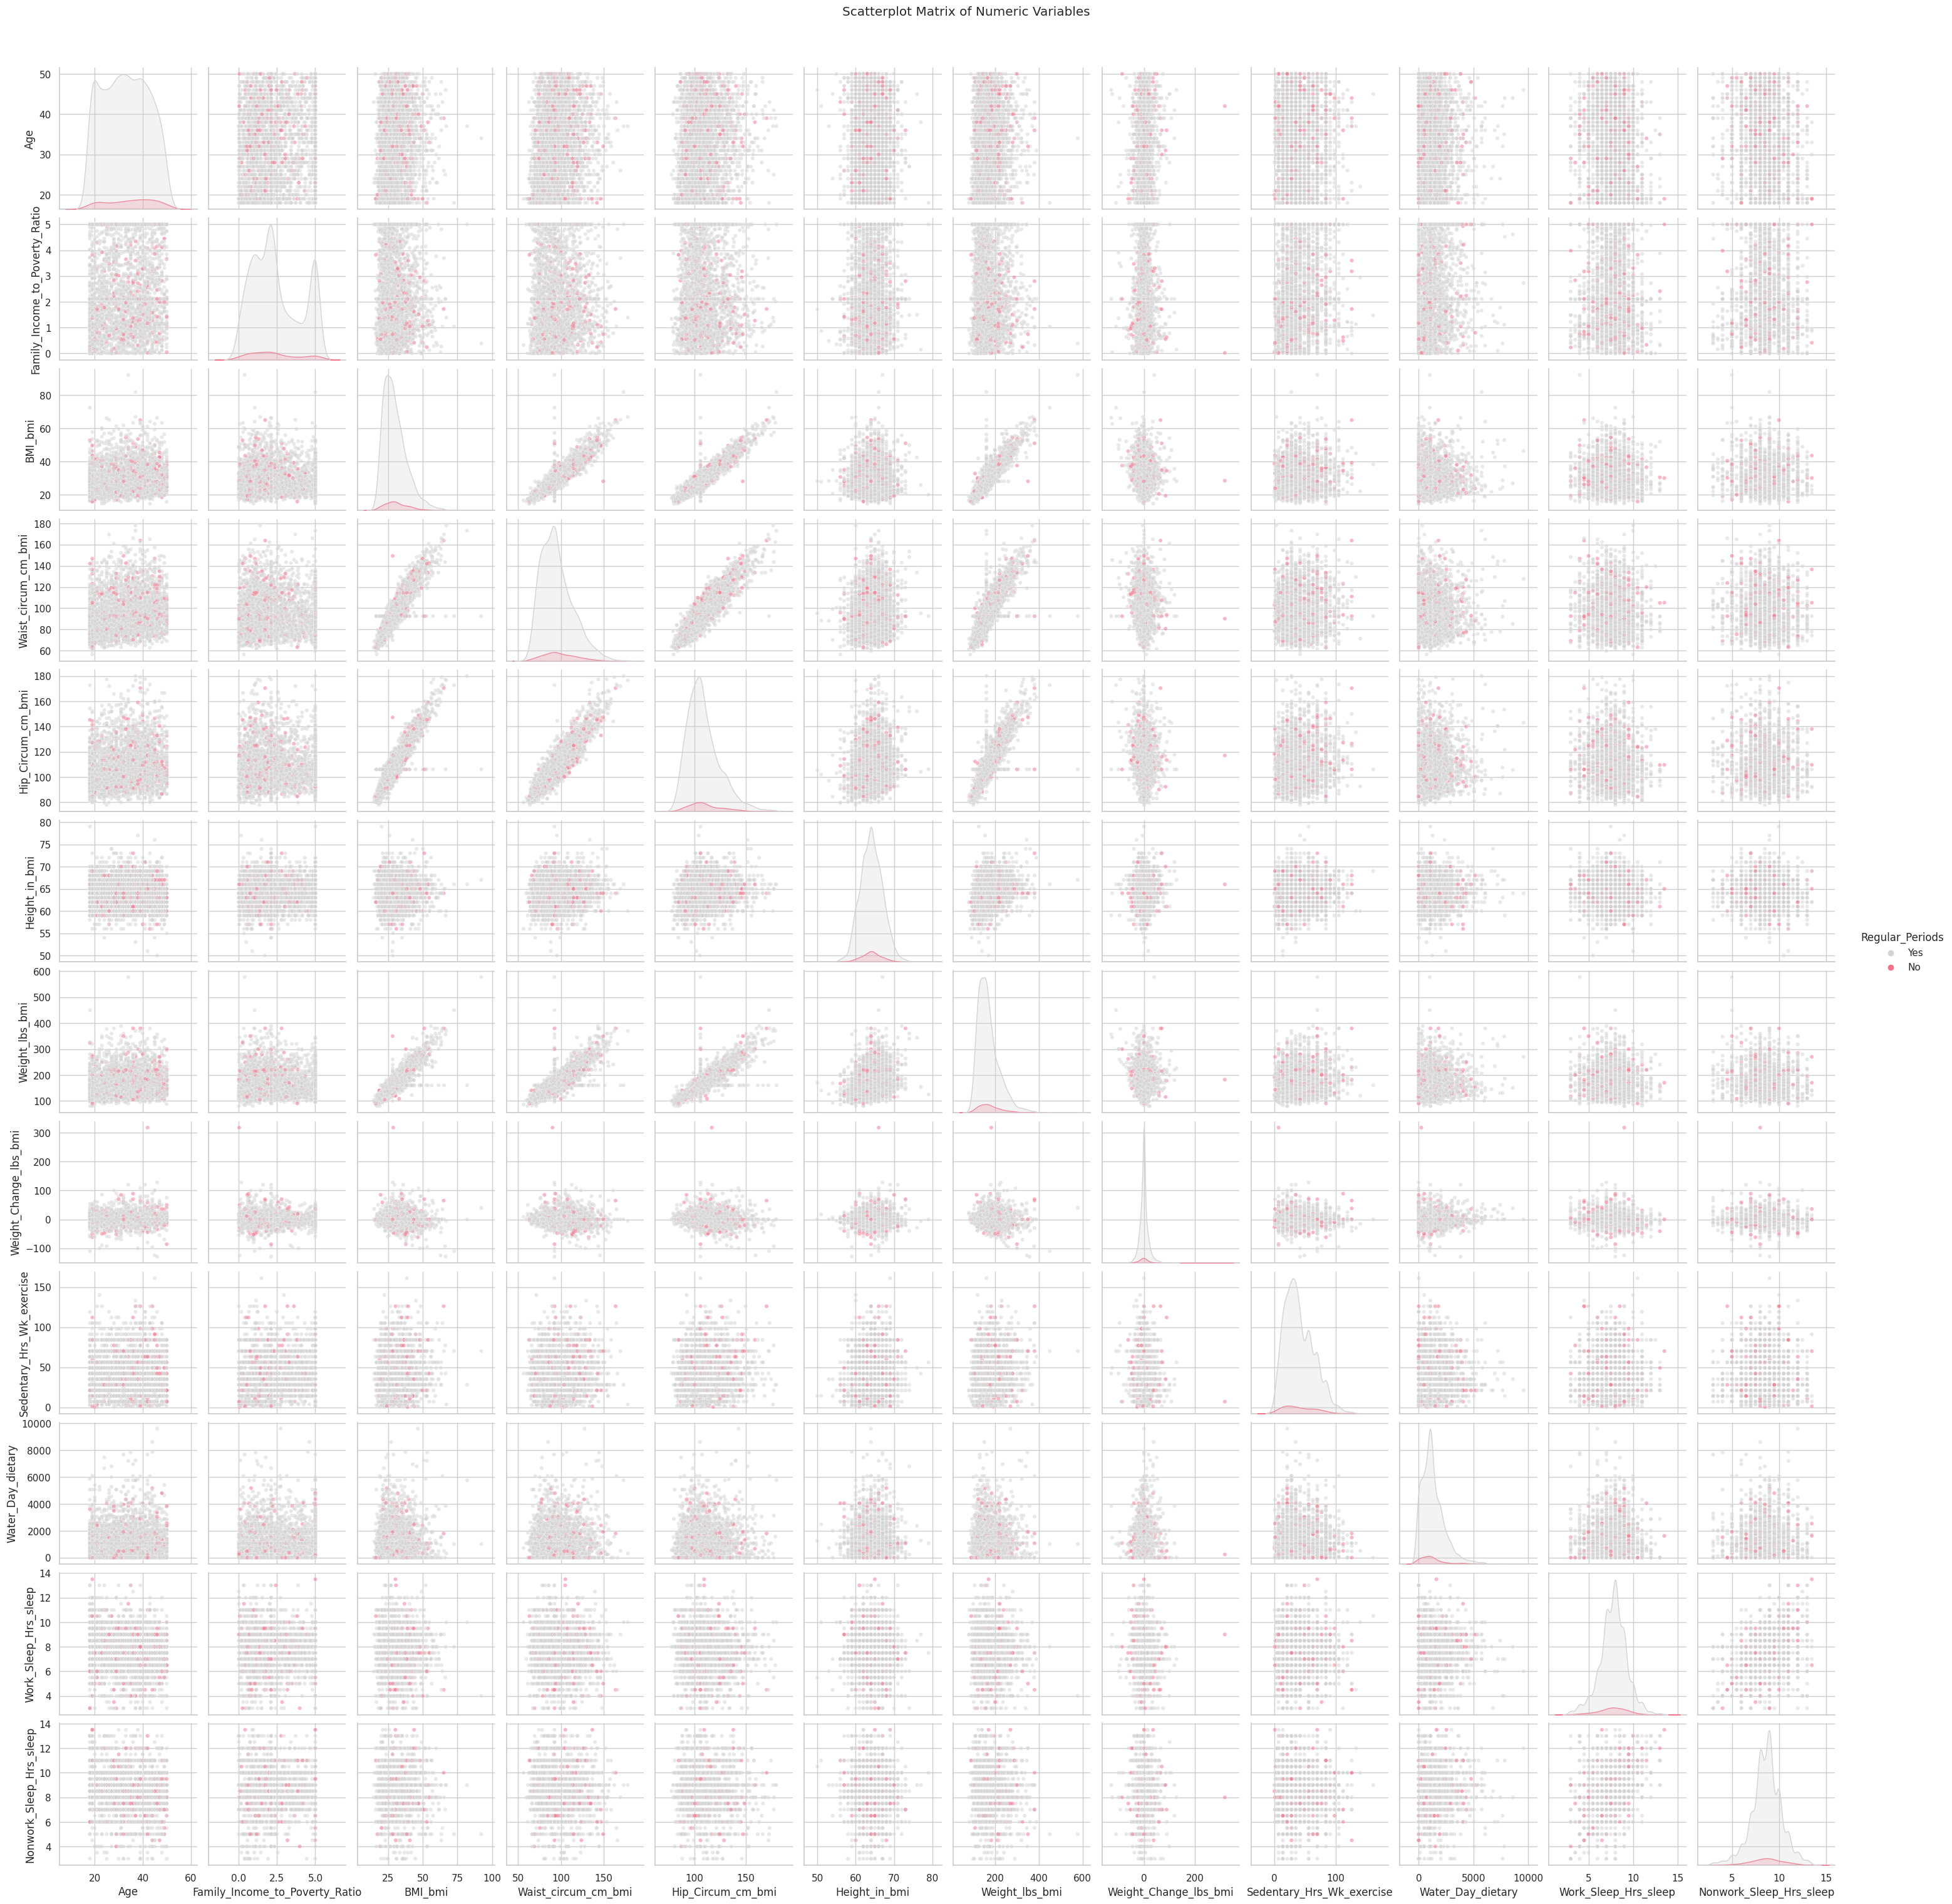

In [3620]:
# Select only numeric columns (exclude participant ID)
numeric_df = cleaned.select_dtypes(include=["int64", "float64"])
numeric_df = numeric_df.drop(columns=["SEQN"])

# Define custom 2-color palette
custom_palette = {
    "Yes": "lightgray",   # regular cycles
    "No": primary_color,      # irregular cycles
}

# Pairplot of numeric variables colored by regular_periods
sns.pairplot(
    numeric_df.join(cleaned["Regular_Periods"]),  # add back outcome for hue
    diag_kind="kde",            # "kde" or "hist" for diagonals
    hue="Regular_Periods",      # color by group
    palette=custom_palette,
    plot_kws={"alpha": 0.5, "s": 20},
)

plt.suptitle("Scatterplot Matrix of Numeric Variables", y=1.02)
plt.show()


### Mann–Whitney U test

In [3621]:
# Map to numeric if not already
cleaned["Regular_Periods"] = cleaned["Regular_Periods"].map({"No": 0, "Yes": 1})

from scipy.stats import pointbiserialr, mannwhitneyu

# ---- Automatically select numeric columns ----
numeric_cols = cleaned.select_dtypes(include=["number"]).columns
numeric_cols = [
    col for col in numeric_cols if col not in ["Regular_Periods", "SEQN"]
]

In [3622]:
# ---- Mann–Whitney U tests with effect size ----
results_m = []

for col in numeric_cols:
    group0 = cleaned.loc[cleaned["Regular_Periods"] == 0, col].dropna()
    group1 = cleaned.loc[cleaned["Regular_Periods"] == 1, col].dropna()

    if len(group0) > 0 and len(group1) > 0:  # avoid empty groups
        stat, p = mannwhitneyu(group0, group1, alternative="two-sided")

        n0, n1 = len(group0), len(group1)
        # Rank-biserial correlation (effect size)
        r_rb = (2 * stat) / (n0 * n1) - 1

        results_m.append(
            {
                "Feature": col,
                "U-statistic": stat,
                "p-value": p,
                "Median_0": group0.median(),
                "Median_1": group1.median(),
                "N_0": n0,
                "N_1": n1,
                "Rank-Biserial_r": r_rb,
            }
        )

# Convert results to DataFrame
mw_df = pd.DataFrame(results_m)

# Keep only significant results (p < 0.05)
mw_df_significant = mw_df[mw_df["p-value"] < 0.05].copy()

# Sort by p-value
mw_df_significant = mw_df_significant.sort_values(by="p-value")

print("\nMann–Whitney U tests (p < 0.05):\n", mw_df_significant)



Mann–Whitney U tests (p < 0.05):
                Feature  U-statistic   p-value  Median_0  Median_1  N_0   N_1  \
3  Waist_circum_cm_bmi     338078.5  0.004728     95.35      92.5  206  2937   
0                  Age     337237.0  0.005788     36.00      33.0  206  2937   
2              BMI_bmi     333686.0  0.013283     29.95      28.2  206  2937   
6       Weight_lbs_bmi     332436.5  0.017434    169.00     160.0  206  2937   
9    Water_Day_dietary     276924.5  0.041795   1072.50    1072.5  206  2937   
4    Hip_Circum_cm_bmi     327360.5  0.048414    107.40     106.0  206  2937   

   Rank-Biserial_r  
3         0.117574  
0         0.114793  
2         0.103054  
6         0.098924  
9        -0.084580  
4         0.082144  


### Outcome

Several variables — including **age, BMI, waist circumference, weight, and hip circumference** — showed statistically significant differences between groups at the 5% level.  
However, all associated effect sizes were small (**rank-biserial correlation, r_rb ≤ 0.12**).  

**Interpretation:**  
While these findings indicate detectable differences, the small effect sizes suggest that the magnitude of these associations is weak. Therefore, results should be interpreted with caution, as statistical significance does not necessarily imply practical or clinical significance.


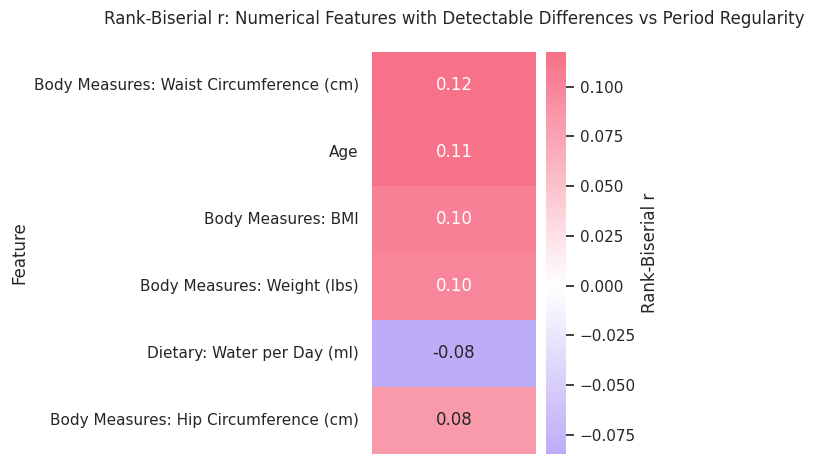

In [3623]:
# Create a dictionary to map the label
label_map = {
    "BMI_bmi": "Body Measures: BMI",
    "Waist_circum_cm_bmi": "Body Measures: Waist Circumference (cm)",
    "Weight_lbs_bmi": "Body Measures: Weight (lbs)",
    "Water_Day_dietary": "Dietary: Water per Day (ml)",
    "Hip_Circum_cm_bmi": "Body Measures: Hip Circumference (cm)",
    "Sedentary_Hrs_Wk_exercise": "Physical Activity: Sedentary hours per week",
    "Nonwork_Sleep_Hrs_sleep": " Sleep: Sleep Hours (Weekends)"
}


# Create a diverging colormap (secondary → white → primary)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [secondary_color, "white", primary_color],
)

# Prepare heatmap data and apply label mapping
heatmap_data = mw_df_significant.set_index("Feature")[["Rank-Biserial_r"]]
heatmap_data = heatmap_data.rename(index=label_map)

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    cbar_kws={"label": "Rank-Biserial r"},
)

plt.title(
    "Rank-Biserial r: Numerical Features with Detectable Differences "
    "vs Period Regularity",
    pad=20
)
plt.ylabel("Feature")
plt.xlabel("")
plt.xticks([])       # hide xtick labels
plt.tight_layout()
plt.show()


In [3624]:
# Extract suffix from feature names (e.g., "BMI_bmi" → "bmi")
mw_df["Group"] = mw_df["Feature"].str.extract(r"_([A-Za-z]+)$")

# Keep the row with the highest Rank-Biserial_r per group
filtered_df = (
    mw_df.loc[mw_df.groupby("Group")["Rank-Biserial_r"].idxmax()]
    .reset_index(drop=True)
)


# Drop row for Family_Income_to_Poverty_Ratio if present
filtered_df = filtered_df[filtered_df["Feature"] != "Family_Income_to_Poverty_Ratio"]

print("Filtered results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):")
print(filtered_df)

Filtered results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):
                     Feature  U-statistic   p-value  Median_0  Median_1  N_0  \
1        Waist_circum_cm_bmi     338078.5  0.004728     95.35      92.5  206   
2          Water_Day_dietary     276924.5  0.041795   1072.50    1072.5  206   
3  Sedentary_Hrs_Wk_exercise     303220.5  0.954870     35.00      35.0  206   
4    Nonwork_Sleep_Hrs_sleep     306329.0  0.759188      9.00       9.0  206   

    N_1  Rank-Biserial_r     Group  
1  2937         0.117574       bmi  
2  2937        -0.084580   dietary  
3  2937         0.002345  exercise  
4  2937         0.012621     sleep  


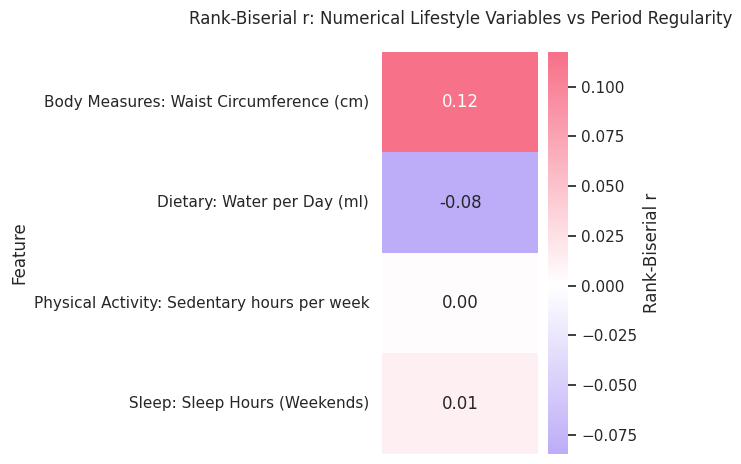

In [3625]:
# Prepare heatmap data and apply label mapping
heatmap_data = filtered_df.set_index("Feature")[["Rank-Biserial_r"]]
heatmap_data = heatmap_data.rename(index=label_map)

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    center=0,
    cbar_kws={"label": "Rank-Biserial r"},
)

plt.title(
    "Rank-Biserial r: Numerical Lifestyle Variables vs Period Regularity",
    pad=20
)
plt.ylabel("Feature")
plt.xlabel("")
plt.xticks([])       # hide xtick labels
plt.tight_layout()
plt.show()


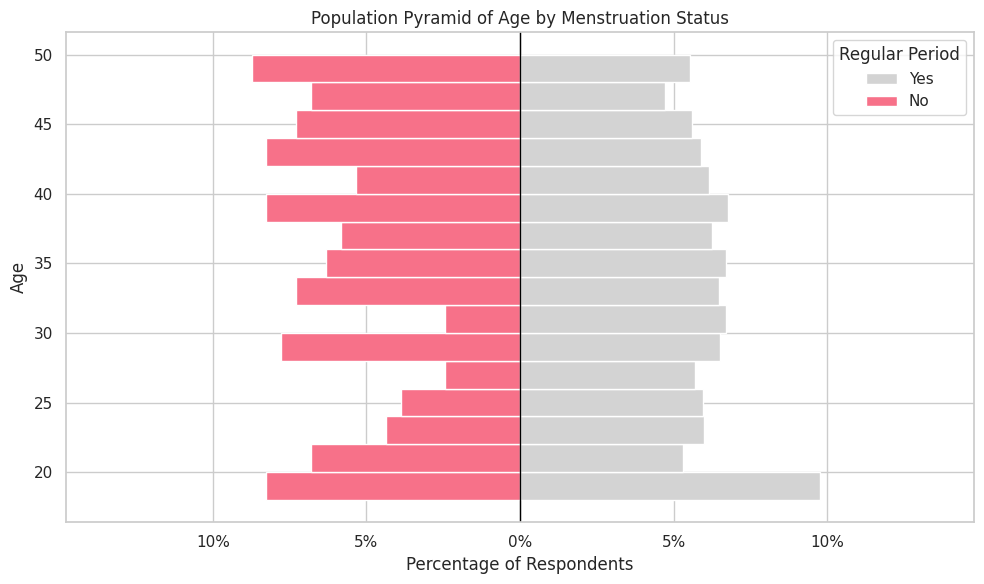

In [3626]:

# Bin the ages
bin_width = 2
bins = range(
    int(cleaned["Age"].min()),
    int(cleaned["Age"].max()) + bin_width,
    bin_width,
)

# Compute histogram data for each group
yes_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 1, "Age"], bins=bins
)
no_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 0, "Age"], bins=bins
)

# Convert to percentages
yes_perc = yes_counts / yes_counts.sum() * 100
no_perc = no_counts / no_counts.sum() * 100

# Midpoints for bin labels
bin_mid = [b + bin_width / 2 for b in bins[:-1]]

# Plot pyramid
plt.figure(figsize=(10, 6))
plt.barh(bin_mid, yes_perc, height=bin_width, color="lightgray", label="Yes")
plt.barh(bin_mid, -no_perc, height=bin_width, color=primary_color, label="No")

# Decorations
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Percentage of Respondents")
plt.ylabel("Age")
plt.title("Population Pyramid of Age by Menstruation Status")

# Find the largest absolute percentage and set symmetric x-axis limits
max_perc = max(yes_perc.max(), no_perc.max())
plt.xlim(-max_perc - 5, max_perc + 5)

# Format x-axis ticks as positive percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}%")
)

plt.legend(title="Regular Period", loc="upper right")
plt.tight_layout()
plt.show()


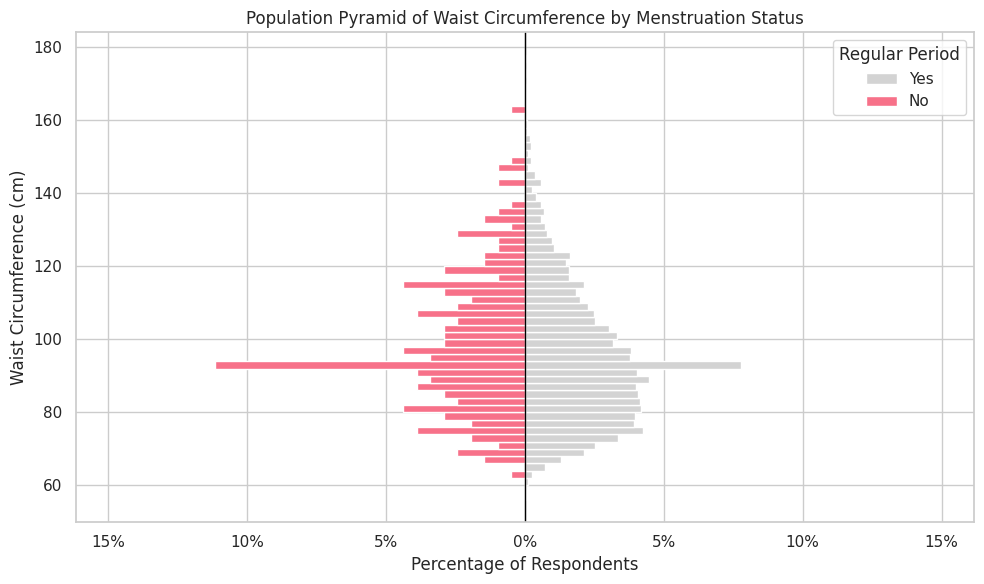

In [3627]:
# Bin the waist circumference
bin_width = 2
bins = range(
    int(cleaned["Waist_circum_cm_bmi"].min()),
    int(cleaned["Waist_circum_cm_bmi"].max()) + bin_width,
    bin_width,
)

# Compute histogram data for each group
yes_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 1, "Waist_circum_cm_bmi"],
    bins=bins,
)
no_counts, _ = np.histogram(
    cleaned.loc[cleaned["Regular_Periods"] == 0, "Waist_circum_cm_bmi"],
    bins=bins,
)

# Convert to percentages
yes_perc = yes_counts / yes_counts.sum() * 100
no_perc = no_counts / no_counts.sum() * 100

# Midpoints for bin labels
bin_mid = [b + bin_width / 2 for b in bins[:-1]]

# Plot pyramid
plt.figure(figsize=(10, 6))
plt.barh(bin_mid, yes_perc, height=bin_width, color="lightgray", label="Yes")
plt.barh(bin_mid, -no_perc, height=bin_width, color=primary_color, label="No")

# Decorations
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Percentage of Respondents")
plt.ylabel("Waist Circumference (cm)")
plt.title("Population Pyramid of Waist Circumference by Menstruation Status")

# Symmetric x-axis limits
max_perc = max(yes_perc.max(), no_perc.max())
plt.xlim(-max_perc - 5, max_perc + 5)

# Format x-axis ticks as positive percentages
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}%")
)

plt.legend(title="Regular Period", loc="upper right")
plt.tight_layout()
plt.show()


## Relationship Between Categorical Variables and Outcome

We investigated associations between categorical predictors and menstrual cycle regularity (`Regular_Periods`) using a stepwise approach:

1. **Statistical Testing (Chi-Square Tests)**  
   - Each categorical variable was first tested against the outcome using a **chi-square test of independence**.  
   - Features with **p < 0.05** were considered to show evidence of association.  
   - Effect size was assessed with **Cramer’s V**, allowing us to prioritize variables with both statistical significance and meaningful association strength.  

2. **Feature Reduction**  
   - Only variables with significant results and interpretable effect sizes were retained for further analysis.  
   - This step reduces noise and ensures subsequent interpretation focuses on the most relevant categorical features.  

3. **Visualization (Contingency Tables & Stacked Bar Charts)**  
   - For the reduced set of features, we created **contingency tables** to summarize group distributions.  
   - To aid interpretation, we plotted **stacked bar charts** comparing the proportions of women with regular vs. irregular cycles across categories.  
   - This visualization highlights relative differences and makes patterns of association more intuitive.  


In [3628]:
# Select categorical columns
categorical_cols = cleaned.select_dtypes(include=["object", "category"]).columns

categorical_cols

Index(['Race', 'Education', 'Attempted_Weight_Loss_bmi', 'Smoked_100_smoking',
       'Household_Smoker_Count_smoking', 'Alc_Freq_alcohol',
       'Daily_Drinks_alcohol', 'Salt_Used_dietary', 'On_Diet_dietary',
       'Dietary_Supp_dietary', 'Work_Sleep_Time_Category_sleep',
       'Work_Wake_Time_Category_sleep', 'Work_Sleep_Hrs_Category_sleep',
       'Nonwork_Sleep_Time_Category_sleep', 'Nonwork_Wake_Time_Category_sleep',
       'Nonwork_Sleep_Hrs_Category_sleep'],
      dtype='object')

### Chi-Square Test of Independence  
#### Cramer’s V Heatmap  

- The analysis begins with a **chi-square test of independence**, which evaluates whether the distribution of a categorical variable differs across groups of the outcome (`Regular_Periods`).  
- To quantify the strength of these associations, we calculate **Cramer’s V** for each variable.  
- **Cramer’s V**:  
  - Derived directly from the chi-square statistic.  
  - Measures the strength (not the direction) of association between two categorical variables.  
  - Values range from **0 (no association)** to **1 (perfect association)**.
- Results are visualized using a **heatmap of Cramer’s V values**, making it easier to compare effect sizes across categorical predictors.  


In [3629]:
from scipy.stats import chi2_contingency

def cramers_v(chi2, n, r, c):
    """Standard Cramér's V."""
    denom = n * (min(r - 1, c - 1))
    return np.sqrt(chi2 / denom) if denom > 0 else np.nan


def cramers_v_bias_corrected(chi2, n, r, c):
    """
    Bias-corrected Cramér's V (Bergsma & Wicher, 2013).
    More reliable with small samples or imbalanced tables.
    """
    if n <= 1:
        return np.nan
    phi2 = chi2 / n
    phi2_corr = max(0.0, phi2 - ((c - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    c_corr = c - ((c - 1) ** 2) / (n - 1)
    denom = min(r_corr - 1, c_corr - 1)
    return np.sqrt(phi2_corr / denom) if denom > 0 else np.nan


def v_label(v):
    """Quick interpretation labels for Cramér’s V."""
    if np.isnan(v):
        return "n/a"
    if v < 0.10:
        return "negligible"
    if v < 0.30:
        return "small"
    if v < 0.50:
        return "medium"
    return "large"


cat_results = []

for col in categorical_cols:
    contingency = pd.crosstab(cleaned["Regular_Periods"], cleaned[col])
    chi2, p_chi2, dof, expected = chi2_contingency(contingency)

    r, c = contingency.shape
    n = contingency.values.sum()

    v = cramers_v(chi2, n, r, c)
    v_bc = cramers_v_bias_corrected(chi2, n, r, c)

    cat_results.append(
        {
            "Feature": col,
            "Rows": r,
            "Cols": c,
            "Chi2": chi2,
            "Chi2_p": p_chi2,
            "CramersV": v,
            "CramersV_biascorr": v_bc,
            "EffectSize": v_label(v_bc if not np.isnan(v_bc) else v),
        }
    )

cat_corr_df = pd.DataFrame(cat_results).sort_values("Chi2_p")
sig_results = cat_corr_df[cat_corr_df["Chi2_p"] < 0.05].sort_values("Chi2_p")

print("Chi-square test of independence with effect size labels:\n", sig_results)


Chi-square test of independence with effect size labels:
                            Feature  Rows  Cols       Chi2    Chi2_p  CramersV  \
0                             Race     2     6  19.280819  0.001704  0.078323   
1                        Education     2     5  14.948211  0.004810  0.068964   
3               Smoked_100_smoking     2     2   5.585656  0.018108  0.042157   
7                Salt_Used_dietary     2     4   9.761126  0.020710  0.055729   
10  Work_Sleep_Time_Category_sleep     2     2   4.661779  0.030841  0.038513   
11   Work_Wake_Time_Category_sleep     2     3   6.858437  0.032412  0.046713   
4   Household_Smoker_Count_smoking     2     3   6.173033  0.045661  0.044318   

    CramersV_biascorr  EffectSize  
0            0.067414  negligible  
1            0.059026  negligible  
3            0.038202  negligible  
7            0.046385  negligible  
10           0.034137  negligible  
11           0.039320  negligible  
4            0.036441  negligible  


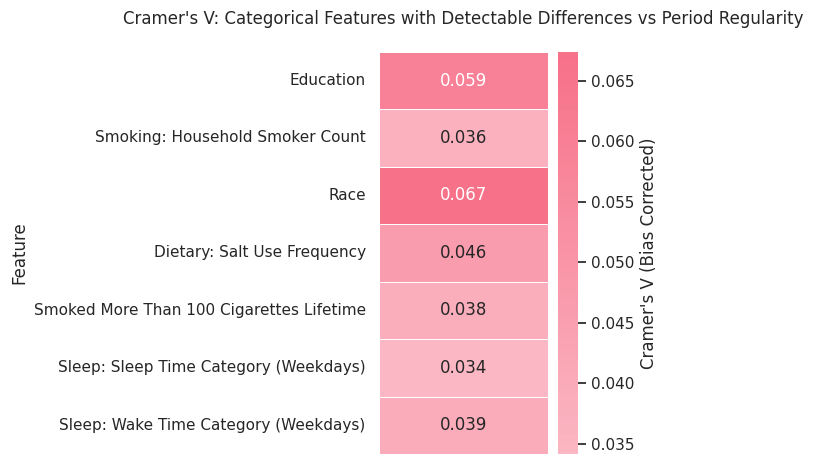

In [3630]:
# Create a dictionary to map the label
label_map_cat = {
    "Smoked_100_smoking": "Smoked More Than 100 Cigarettes Lifetime",
    "Salt_Used_dietary": "Dietary: Salt Use Frequency",
    "Work_Sleep_Time_Category_sleep": "Sleep: Sleep Time Category (Weekdays)",
    "Nonwork_Sleep_Time_Category_sleep": "Sleep: Sleep Time Category (Weekends)",
    "Work_Wake_Time_Category_sleep": "Sleep: Wake Time Category (Weekdays)",
    "Household_Smoker_Count_smoking": "Smoking: Household Smoker Count"
}


# Pivot the DataFrame to make a heatmap-ready matrix
heatmap_data = sig_results.pivot(
    index="Feature",
    columns="Rows",
    values="CramersV_biascorr",
)

#Change the label
heatmap_data = heatmap_data.rename(index=label_map_cat)


sns.heatmap(
    heatmap_data,
    annot=True,  # show the numeric values
    cmap=custom_cmap,  # custom diverging colormap
    center=0,  # center colormap
    linewidths=0.5,
    cbar_kws={"label": "Cramer's V (Bias Corrected)"},
)

plt.title(
    "Cramer's V: Categorical Features with Detectable Differences "
    "vs Period Regularity",
    pad=20
)
plt.ylabel("Feature")
plt.xticks([])  # remove the x-axis ticks
plt.xlabel("")  # remove the x-axis label
plt.tight_layout()
plt.show()


In [3631]:
# Extract suffix from feature names (e.g., "Race_demo" → "demo")
sig_results["Group"] = sig_results["Feature"].str.extract(r"_([A-Za-z]+)$")

# Keep the row with the highest Cramér’s V (bias corrected) per group
filtered_cat_df = (
    sig_results.loc[sig_results.groupby("Group")["CramersV_biascorr"].idxmax()]
    .reset_index(drop=True)
)


print(
    "Filtered categorical results (highest effect size per group, "
    "excluding Family_Income_to_Poverty_Ratio):"
)
print(filtered_cat_df)


Filtered categorical results (highest effect size per group, excluding Family_Income_to_Poverty_Ratio):
                         Feature  Rows  Cols      Chi2    Chi2_p  CramersV  \
0              Salt_Used_dietary     2     4  9.761126  0.020710  0.055729   
1  Work_Wake_Time_Category_sleep     2     3  6.858437  0.032412  0.046713   
2             Smoked_100_smoking     2     2  5.585656  0.018108  0.042157   

   CramersV_biascorr  EffectSize    Group  
0           0.046385  negligible  dietary  
1           0.039320  negligible    sleep  
2           0.038202  negligible  smoking  


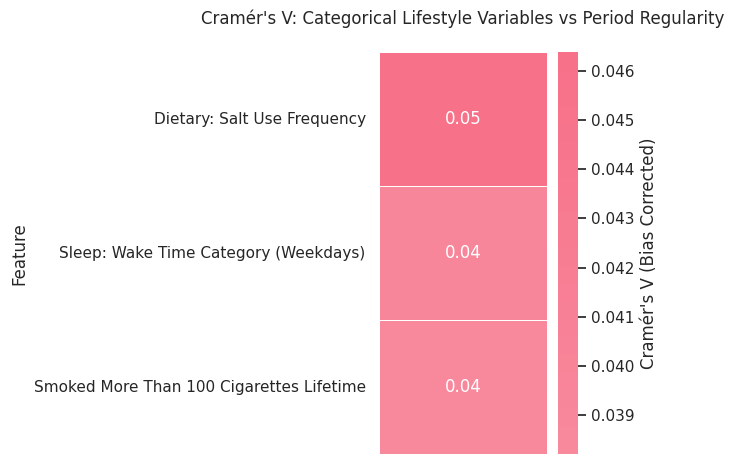

In [3632]:
# Prepare heatmap data (Feature vs Cramér's V bias corrected)
heatmap_data = filtered_cat_df.set_index("Feature")[["CramersV_biascorr"]]

# Apply label mapping
heatmap_data = heatmap_data.rename(index=label_map_cat)

# Plot heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=0.5,
    center=0,
    cbar_kws={"label": "Cramér's V (Bias Corrected)"},
)

plt.title(
    "Cramér's V: Categorical Lifestyle Variables vs Period Regularity",
    pad=20,
)
plt.ylabel("Feature")
plt.xlabel("")
plt.xticks([])  # remove the x-axis ticks
plt.tight_layout()
plt.show()


In [3633]:
def plot_stacked_bars_all(df, target, features, label_map=None, normalize=True):
    """
    Plot stacked bar charts of categorical features vs a binary target.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset.
    target : str
        Column to use as x-axis (e.g., "Regular_Periods").
    features : list[str]
        List of categorical feature names to plot.
    label_map : dict, optional
        Mapping from column names to human-readable labels.
    normalize : bool, default=True
        If True, bars show row percentages (each bar sums to 100).
    """
    results = {}
    target_map = {0: "No", 1: "Yes"}

    for col in features:
        # Build contingency table
        ct = pd.crosstab(
            df[target],
            df[col],
            normalize="index" if normalize else False,
        )
        if normalize:
            ct = ct * 100
        results[col] = ct

        # Remap x-axis labels (0/1 -> No/Yes)
        ct.index = ct.index.map(target_map)

        # Human-readable labels for feature/target
        col_label = label_map.get(col, col) if label_map else col
        target_label = "Menstrual Cycle Regularity"  # nicer axis label

        # Plot
        ax = ct.plot(
            kind="bar",
            stacked=True,
            figsize=(8, 4),
        )

        plt.title(
            f"{col_label} by {target_label} "
            f"({'%' if normalize else 'Counts'})",
            pad=20,
        )
        plt.xlabel("Regular Period")
        plt.ylabel("Percentage (%)" if normalize else "Count")

        # Keep y-axis 0-100 for percentage charts
        if normalize:
            ax.set_ylim(0, 100)

        plt.legend(
            title=col_label,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            frameon=False,
        )
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

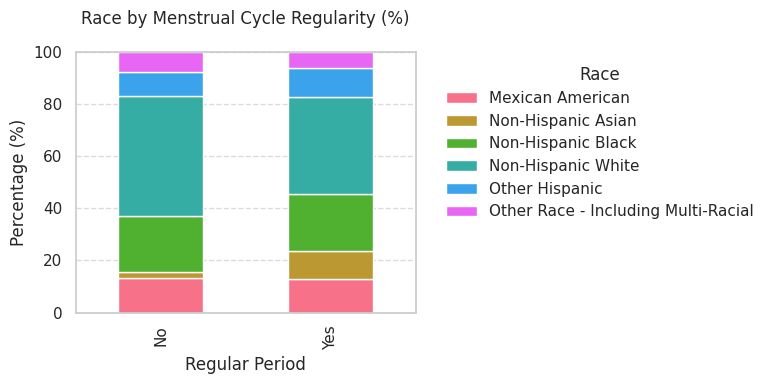

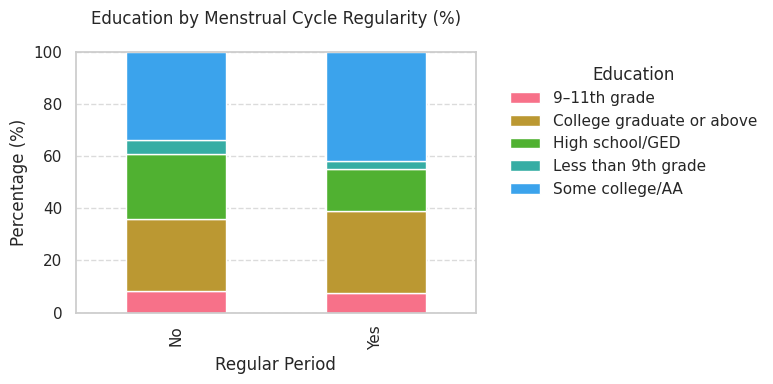

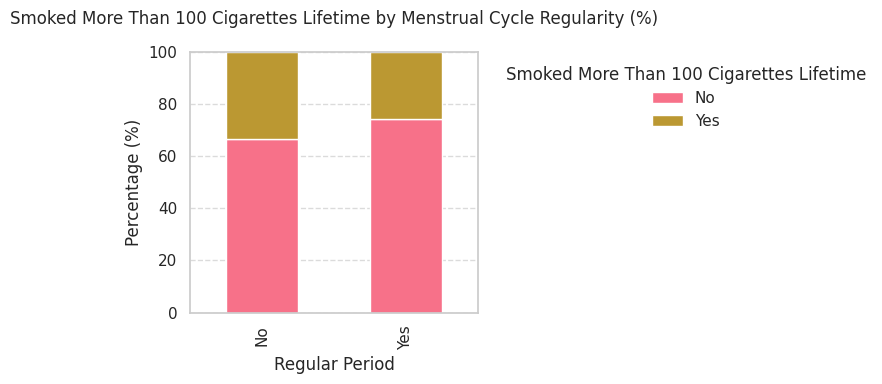

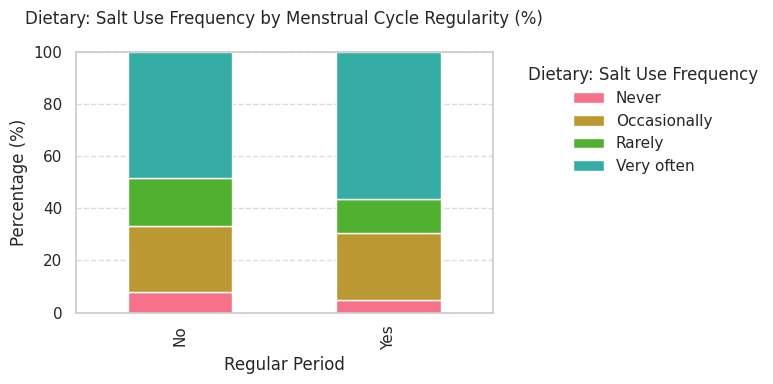

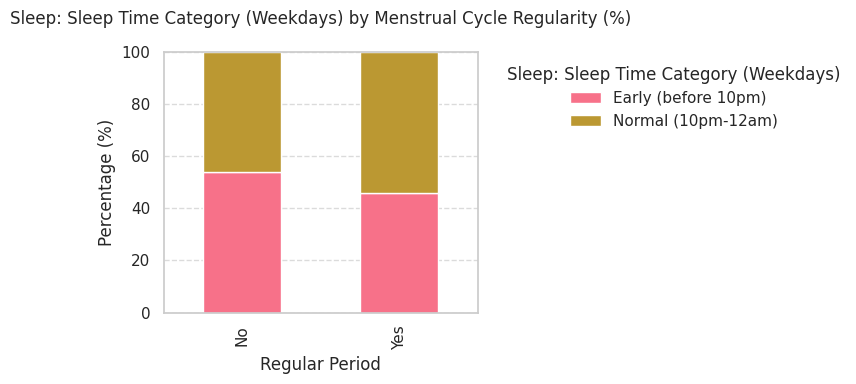

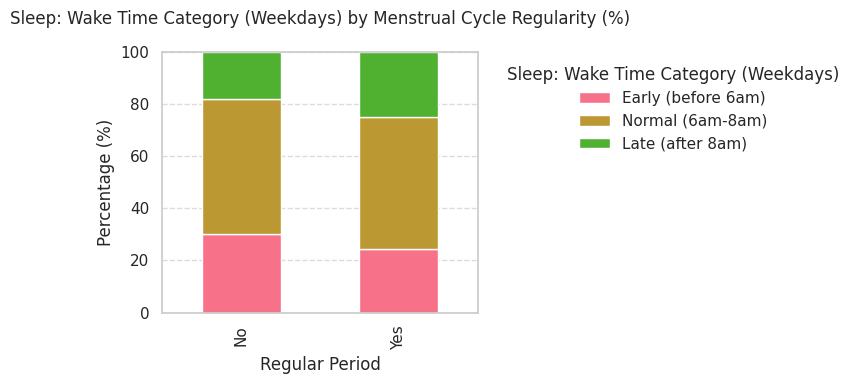

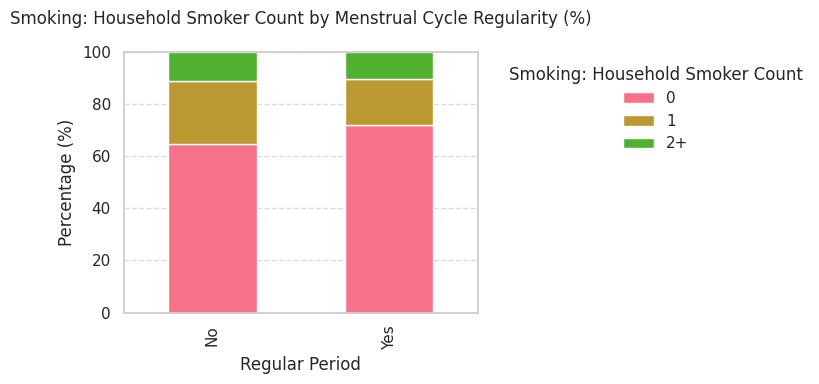

In [3634]:
categorical_vars = sig_results['Feature']
plot_stacked_bars_all(cleaned, "Regular_Periods", categorical_vars,label_map=label_map_cat)

### Outcome

Several variables — including age, BMI, waist circumference, weight, and hip circumference — showed statistically significant differences between groups at the 5% level.
However, all associated effect sizes were small (rank-biserial correlation, r_rb ≤ 0.12).

Interpretation:

- The rank-biserial correlation (r_rb) quantifies the strength of difference between two groups.

- Common thresholds:

     - < 0.10 → negligible

     - 0.10 – 0.30 → small

     - 0.30 – 0.50 → medium

     - ≥ 0.50 → large

- While these findings indicate detectable differences, the effect sizes fall in the negligible to small range, suggesting that the magnitude of association is weak.

- Therefore, results should be interpreted with caution, as statistical significance does not imply practical or clinical significance.

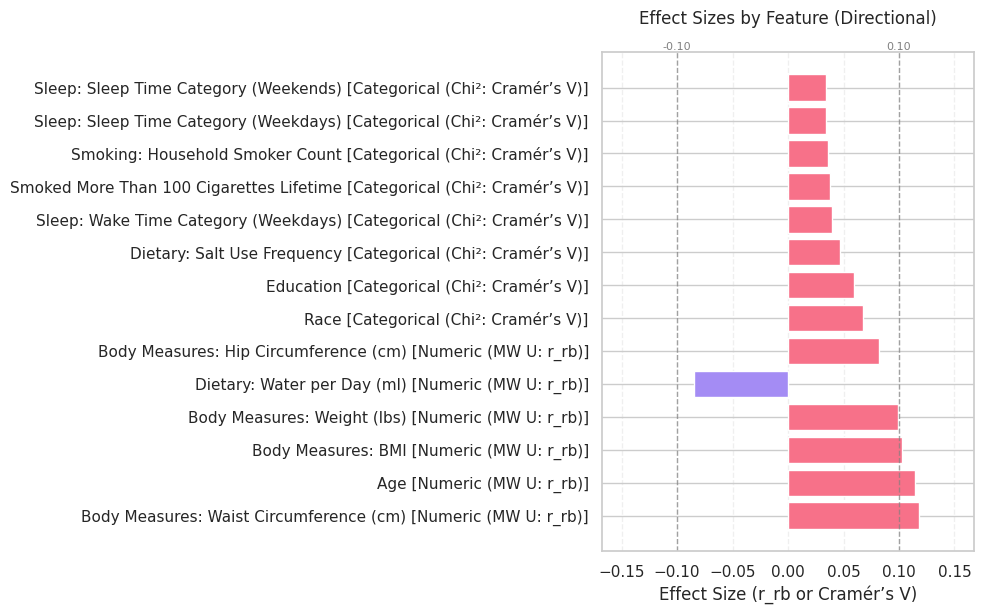

In [3635]:
if eff_all.empty:
    print(
        "No effects to plot with current filter (e.g., p < 0.05). "
        "Consider setting sig_only=False."
    )
else:
    # ------- Plot: horizontal bar chart of effect sizes -------
    try:
        merged_labels = {**label_map, **label_map_cat}
    except NameError:
        merged_labels = {}

    eff_all["PrettyFeature"] = eff_all["Feature"].map(
        lambda x: merged_labels.get(x, x)
    )

    plt.figure(figsize=(10, max(4, 0.45 * len(eff_all))))

    y_pos = np.arange(len(eff_all))

    # Color bars by sign
    colors = [primary_color if v >= 0 else secondary_color for v in eff_all["Effect"]]

    plt.barh(y_pos, eff_all["Effect"], color=colors)

    # Y tick labels show feature and (type)
    y_labels = [
        f"{feat} [{typ}]"
        for feat, typ in zip(eff_all["PrettyFeature"], eff_all["Type"])
    ]
    plt.yticks(y_pos, y_labels)

    # Symmetric x-limits around 0
    max_abs = float(eff_all["AbsEffect"].max())
    pad = 0.05
    plt.xlim(-(max_abs + pad), max_abs + pad)

    # Reference threshold: ±0.10
    for sign in (-1, 1):
        plt.axvline(
            x=sign * 0.10,
            linestyle="--",
            color="gray",
            linewidth=1,
            alpha=0.7,
        )
        plt.text(
            sign * 0.10,
            plt.ylim()[1],   # position at top of plot
            f"{sign * 0.10:.2f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="gray",
        )

    plt.xlabel("Effect Size (r_rb or Cramér’s V)")
    plt.title("Effect Sizes by Feature (Directional)",
             pad=20)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


## Logistic Regression Analysis

After exploring bivariate associations with nonparametric tests and effect sizes, we next apply **logistic regression** to model the probability of having **regular menstrual cycles** as a function of lifestyle and demographic predictors, using only the predictors that showed statistically significant associations in the preliminary analysis.

- **Outcome variable**  
  - `Regular_Periods` (binary: `0 = irregular`, `1 = regular`)  

- **Predictor variables**  
  - Continuous measures (e.g., BMI, waist circumference, sleep hours)  
  - Categorical factors (e.g., race, smoking history, salt use, sleep timing)  

- **Why logistic regression?**  
  - Estimates the **odds ratio (OR)** for each predictor  
  - Quantifies how a one-unit increase (continuous) or category membership (categorical) changes the likelihood of regular cycles  
  - Adjusts for **multiple predictors simultaneously**, providing a multivariable perspective beyond pairwise tests  

- **Outputs of interest**  
  - **Odds Ratios (ORs)** with 95% Confidence Intervals  
  - **p-values** for statistical significance  
  - **Model fit** metrics (e.g., pseudo R², AIC/BIC)  

**Interpretation**  
- OR > 1 → Higher odds of regular cycles  
- OR < 1 → Lower odds of regular cycles  
- Provides a **multivariable view** of how lifestyle and demographics jointly relate to menstrual regularity  


In [3636]:
# Remove the unique identifier
model_data = cleaned.drop(columns=["SEQN"])

# Combine numeric and categorical effects
effects = pd.concat([num_eff, cat_eff], ignore_index=True)

# Filter to statistically significant features (p < 0.05)
sig_effects = effects[effects["p"] < 0.05]

# Get unique feature names
selected_features = sig_effects["Feature"].unique().tolist()

# Keep only selected features plus the target column
model_data = cleaned[selected_features + ["Regular_Periods"]]

In [3637]:
# ==== 1) Target and Features ====
TARGET = "Regular_Periods"

# Ensure target is binary 0/1 (safe if already coded as such)
y = (
    model_data[TARGET]
    .replace({"Yes": 1, "No": 0, "Y": 1, "N": 0, True: 1, False: 0})
    .astype(int)
)

X_raw = model_data.drop(columns=[TARGET])

# ==== 2) Encode Categoricals (no imputation) ====
# get_dummies leaves numeric columns untouched
X = pd.get_dummies(X_raw, drop_first=False)

# Convert boolean columns to integers
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)

# ==== 3) Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# ==== 4) Fit Balanced Logistic Regression ====
logreg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="liblinear",
    penalty="l2",
    random_state=42,
)

logreg.fit(X_train, y_train)

# ==== 5) Evaluate Model ====
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_prob):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy : 0.5954
Precision: 0.9464
Recall   : 0.6008
F1 Score : 0.7350
ROC AUC  : 0.6394

Confusion Matrix:
 [[ 27  25]
 [293 441]]

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.52      0.15        52
           1       0.95      0.60      0.74       734

    accuracy                           0.60       786
   macro avg       0.52      0.56      0.44       786
weighted avg       0.89      0.60      0.70       786



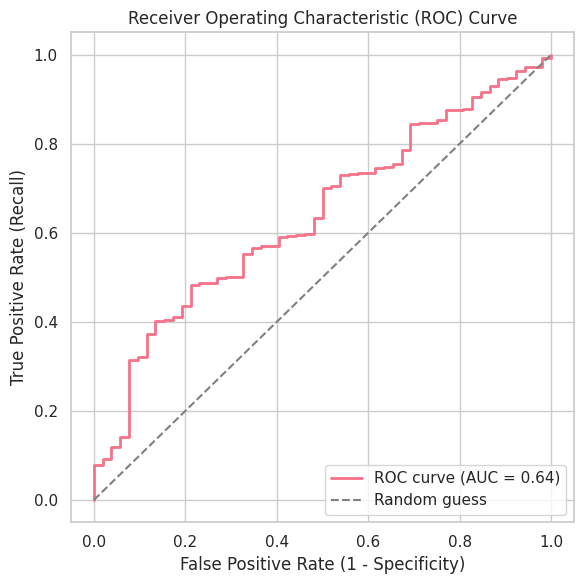

In [3638]:
# Get predicted probabilities for the positive class (1)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(
    fpr,
    tpr,
    linewidth=2,
    label=f"ROC curve (AUC = {roc_auc:.2f})"
)
plt.plot(
    [0, 1],
    [0, 1],
    color="gray",
    linestyle="--",
    label="Random guess"
)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


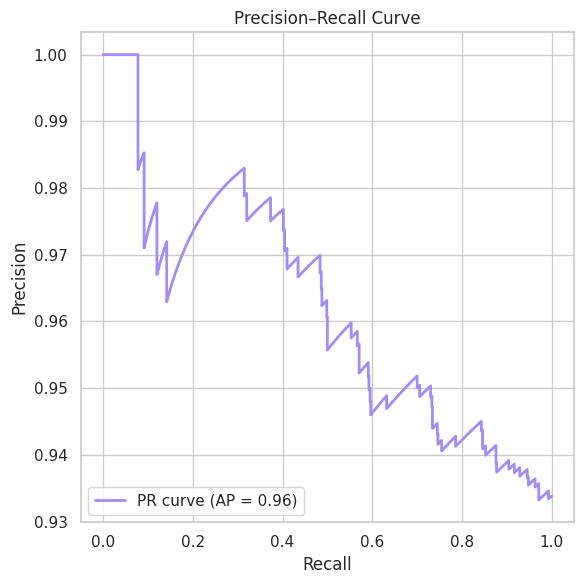

In [3639]:
# Predicted probabilities for the positive class
y_prob = logreg.predict_proba(X_test)[:, 1]

# Precision–recall at various thresholds
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)

# Average precision (area under PR curve)
ap = average_precision_score(y_test, y_prob)

# Plot Precision–Recall curve
plt.figure(figsize=(6, 6))
plt.plot(
    rec,
    prec,
    color=secondary_color,
    linewidth=2,
    label=f"PR curve (AP = {ap:.2f})"
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


### Logistic Regression Results  


### Interpretation  

- The model shows **very poor precision for irregular cycles (0.08)**, meaning that when it predicts an irregular cycle, it is almost always wrong.  
- Recall for irregular cycles is moderate (0.52), but the large number of false positives makes these predictions unreliable.  
- Predictions for regular cycles dominate overall performance (**precision = 0.95**, F1 = 0.74), but recall is still only moderate (0.60).  
- Overall, the model achieves **60% accuracy**, but this is driven almost entirely by the majority class.
- Odds Ratios (ORs) provide additional insights:

     - OR > 1 → the predictor increases the odds of having regular cycles.

     - OR < 1 → the predictor decreases the odds (i.e., higher likelihood of irregular cycles).

     - For continuous predictors (e.g., age, BMI), the OR is interpreted per unit increase; for categorical predictors, ORs compare each level to a reference group.

     - In practice, most ORs were close to 1, meaning that predictors only weakly shifted the odds of regularity, even when statistically significant.


### Summary  

Logistic regression was applied to test whether lifestyle and demographic predictors could explain menstrual cycle regularity.  

- The **ROC curve (AUC ≈ 0.64)** and **Precision–Recall curve** confirm weak discriminatory power.  
- The **confusion matrix** highlights strong bias toward the majority class (regular periods).  
- While some predictors show associations in bivariate testing, the **multivariate logistic regression does not provide reliable prediction** of cycle regularity.
- Odds ratio analysis confirms that effect sizes are small and close to neutral (OR ≈ 1), limiting predictive usefulness,  

**Conclusion:** Logistic regression reveals that the available features do not predict the outcome well, particularly for irregular cycles, where precision is extremely low.  
 


In [3640]:
# Get coefficients and feature names
coef = logreg.coef_[0]  # Coefficients for class = 1
features = X_train.columns

# Put into DataFrame
odds_df = (
    pd.DataFrame({
        "feature": features,
        "coef": coef,
        "odds_ratio": np.exp(coef)
    })
    .sort_values("odds_ratio", ascending=False)
)

# Display top increasing odds
print(odds_df.head(10))

# Display top decreasing odds
print(odds_df.tail(10))

                                              feature      coef  odds_ratio
7                             Race_Non-Hispanic Asian  1.050069    2.857847
16                          Education_Some college/AA  0.313665    1.368431
31     Work_Wake_Time_Category_sleep_Late (after 8am)  0.301642    1.352077
13                Education_College graduate or above  0.209298    1.232812
22                       Salt_Used_dietary_Very often  0.174760    1.190961
10                                Race_Other Hispanic  0.169047    1.184175
24  Work_Sleep_Time_Category_sleep_Normal (10pm-12am)  0.103429    1.108967
32                   Household_Smoker_Count_smoking_0  0.065733    1.067942
34                  Household_Smoker_Count_smoking_2+  0.065379    1.067564
27  Nonwork_Sleep_Time_Category_sleep_Normal (10pm...  0.044682    1.045695
                                              feature      coef  odds_ratio
26  Nonwork_Sleep_Time_Category_sleep_Early (befor... -0.124242    0.883166
19          

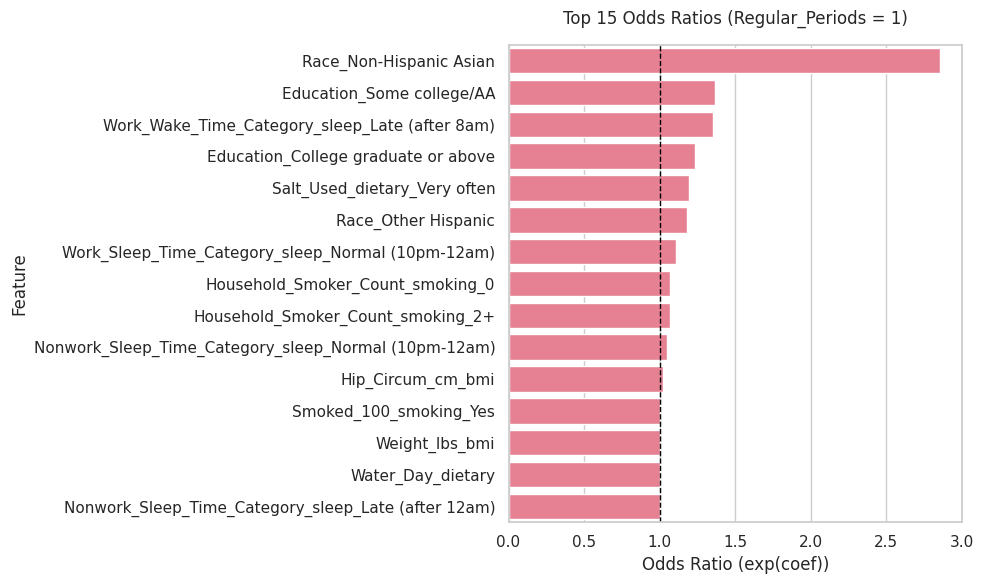

In [3641]:
# Plot top 15 features by odds ratio
plt.figure(figsize=(10, 6))
sns.barplot(
    data=odds_df.sort_values("odds_ratio", ascending=False).head(15),
    x="odds_ratio",
    y="feature",
    color= primary_color
)
plt.axvline(1, color="black", linestyle="--", linewidth=1)
plt.title("Top 15 Odds Ratios (Regular_Periods = 1)", pad=15)
plt.xlabel("Odds Ratio (exp(coef))")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [3642]:
# 1) Build an odds-ratio table from your fitted model
def make_odds_df(logreg, X_train):
    coef = logreg.coef_[0]
    odds = np.exp(coef)
    df = pd.DataFrame({
        "feature": X_train.columns,
        "coef": coef,
        "odds_ratio": odds,
        "log_or_abs": np.abs(coef),  # |log(OR)| = effect magnitude
    })
    return df

# 2) Infer the original categorical "group" from dummy names.
#    If you used a custom prefix_sep in get_dummies, put it here.
def infer_group(col, prefer_sep="__"):
    if prefer_sep in col:
        return col.split(prefer_sep, 1)[0]
    # fallback: split on first underscore
    if "_" in col:
        return col.split("_", 1)[0]
    return col

def add_groups(odds_df, prefer_sep="__"):
    odds_df = odds_df.copy()
    odds_df["group"] = odds_df["feature"].apply(lambda c: infer_group(c, prefer_sep))
    return odds_df


In [3643]:
# 3) Plot: per-dummy odds ratios, grouped (horizontal bars)
def plot_grouped_odds(odds_df, top_n_per_group=3):
    df = odds_df.sort_values("log_or_abs", ascending=False)
    # take top k per group to keep plot readable
    df = df.groupby("group", group_keys=False).head(top_n_per_group)

    # order bars by effect size
    df = df.sort_values("log_or_abs", ascending=True)

    plt.figure(figsize=(10, max(5, int(len(df) * 0.35))))
    plt.hlines(y=df["feature"], xmin=1, xmax=df["odds_ratio"])
    plt.plot(df["odds_ratio"], df["feature"], "o")
    plt.axvline(1.0, linestyle="--")
    plt.xlabel("Odds Ratio (exp(coef))")
    plt.ylabel("Dummy (category level)")
    plt.title(f"Top {top_n_per_group} category levels per feature by effect size (Odds Ratios)")
    plt.tight_layout()
    plt.show()

# 4) Plot: collapsed to one bar per original feature (direction of strongest level)
def plot_group_summary(odds_df, top_groups=15):
    # choose each group's strongest level by |log(OR)|, keep its sign for direction
    strongest = (
        odds_df.loc[odds_df.groupby("group")["log_or_abs"].idxmax()]
        .sort_values("log_or_abs", ascending=False)
        .head(top_groups)
    )
    plt.figure(figsize=(8, max(5, int(len(strongest)*0.5))))
    y = strongest["group"]
    x = strongest["odds_ratio"]
    plt.hlines(y=y, xmin=1, xmax=x)
    plt.plot(x, y, "o")
    plt.axvline(1.0, linestyle="--")
    plt.xlabel("Odds Ratio of strongest level (per feature)")
    plt.ylabel("Feature")
    plt.title("Most influential categorical features (via strongest level)")
    plt.tight_layout()
    plt.show()

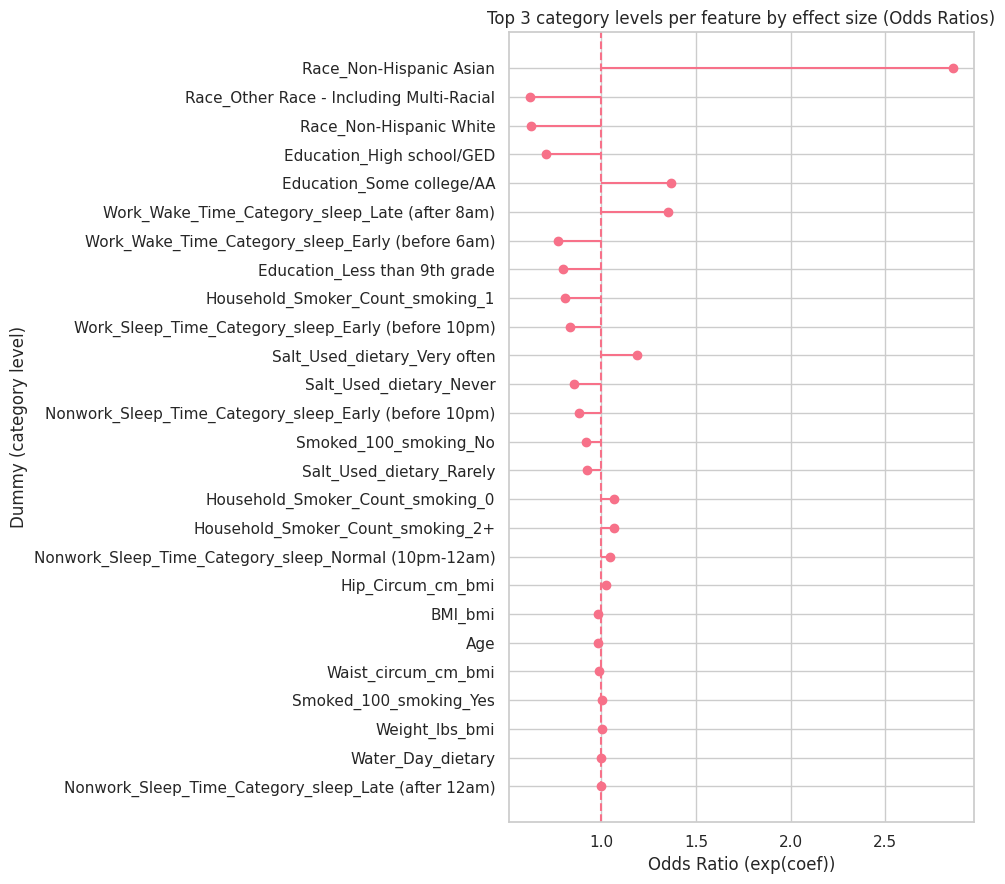

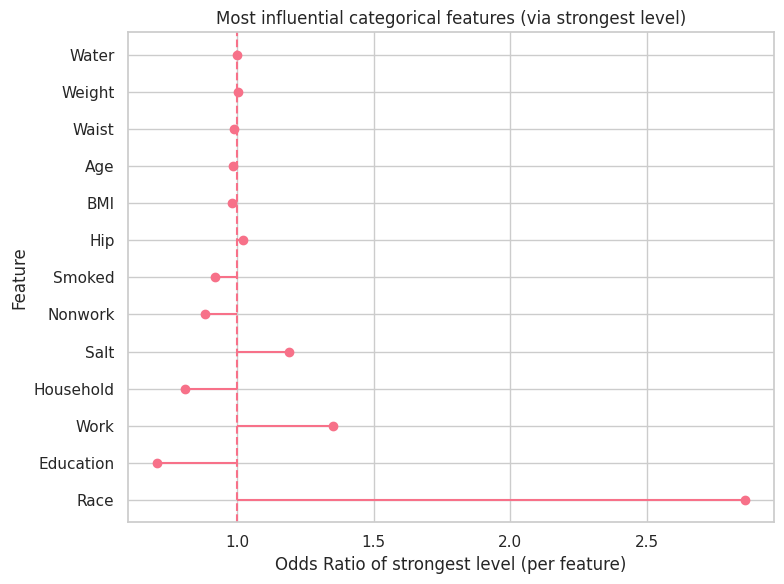

In [3644]:
odds_df = make_odds_df(logreg, X_train)

# If you created dummies like: pd.get_dummies(..., prefix_sep="__"),
# pass prefer_sep="__" so grouping is exact.
odds_df = add_groups(odds_df, prefer_sep="__")  # change to "_" if that's what you used

# Show top category levels per feature (e.g., 2 or 3 per feature)
plot_grouped_odds(odds_df, top_n_per_group=3)

# And a concise one-bar-per-feature summary
plot_group_summary(odds_df, top_groups=15)